### FOM study via isaura data for LPR


You must choose the file inserted here for this to work

In [1]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

In [2]:
#adding here ROI
emin = 1.5
emax = 1.7

#### Collecting all the data

In [3]:

# list of all files in a folder
folder_path = '../LPR_rerun_voxel/isaura_15x15x15mm/PORT_1a/prod/isaura/'
#file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# NOTE Break this section up, its annoying like this.
dfs = []
df_trs = []
df_ems = []
# create massive dataframe with all of them
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_trs.append(df_ps)
    df_ems.append(df_em)

tracks = pd.concat(dfs, axis=0, ignore_index=True)

particles = pd.concat(df_trs, ignore_index=True)
eventmap = pd.concat([dt for dt in df_ems])
# create particle list also

In [4]:
print("Tracks: ")
display(tracks.tail())
print(tracks['event'].nunique())
print("")
print("MC data")
display(particles.tail())
print("")
print("Event map:")
display(eventmap.head())

Tracks: 


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
189473,4060708,1,0.121964,20.069324,3,1689,3,187.675,341.675,304.032379,...,308.081912,202.815692,361.157542,308.356360,0.121667,0.121094,0.120797,13.333333,15.0,14.789446
189474,4060708,2,0.033485,20.069324,2,457,3,147.675,360.675,386.938629,...,389.520812,163.627970,365.698728,389.654063,0.033368,0.032802,0.032685,13.333333,15.0,14.789446
189475,4060710,0,0.572125,52.800000,21,7827,1,305.675,284.675,522.397217,...,529.509638,331.248510,294.552058,526.619440,0.242639,0.188812,0.000000,14.750000,13.2,11.883850
189476,4060712,0,0.888838,93.553991,35,6761,2,-6.325,415.675,335.498718,...,346.560197,25.349946,477.323860,418.388821,0.759932,0.028161,0.000000,12.666667,14.2,14.509995
189477,4060712,1,0.000585,0.000000,1,18,2,65.675,424.675,350.184662,...,350.184662,67.733877,426.232716,350.184662,0.000585,0.000585,0.000585,12.666667,14.2,14.509995


100009

MC data


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
8041796,2030356,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.0,0.0,0.0,0.025482,1.436975,eIoni,eIoni
8041797,2030356,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.0,-0.0,-0.0,0.037231,2.202024,eIoni,eIoni
8041798,2030356,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.0,0.0,-0.0,0.016253,0.597368,eIoni,eIoni
8041799,2030356,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.0,0.0,-0.0,0.033170,1.671516,eIoni,eIoni
8041800,2030356,53,Pb208,False,36,396.074768,394.611877,530.918335,0.000739,396.078827,...,2.427084,-0.653481,0.719626,0.0,-0.0,0.0,0.000018,0.004373,RadioactiveDecay,NoProcess



Event map:


,evt_number
nexus_evt,
2540000,5080000
2540001,5080002
2540002,5080004
2540003,5080006
2540004,5080008


#### Checking that the MC data indexing is just half the track index, and matching the indices accordingly

In [5]:
# double check that this is a valid solution

eventmap_reset = eventmap.reset_index()
display(eventmap_reset)

if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
    print("Falses in here!")
else:
    print("No Falses to be seen!")

,nexus_evt,evt_number
0,2540000,5080000
1,2540001,5080002
2,2540002,5080004
3,2540003,5080006
4,2540004,5080008
...,...,...
100004,2030352,4060704
100005,2030353,4060706
100006,2030354,4060708
100007,2030355,4060710


No Falses to be seen!


In [6]:
# So we're updating it here
particles['event_id'] = particles['event_id'] * 2 
display(particles.head())

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,5080000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,5080000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,5080000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,5080000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot


#### Select a specific event just to check for anything weird happening

In [7]:
# select a specific event
n = 2
evnt = tracks.event.unique()[n]
print("Event of interest: {}".format(evnt))

trk = tracks[tracks.event==evnt]
trk.head()

Event of interest: 5080004


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,5080004,0,0.475855,33.046321,5,4467,2,19.675,-316.325,147.604263,...,154.720772,38.507312,-310.859095,153.875947,0.406043,0.388595,0.318784,13.333333,13.833333,14.51091
4,5080004,1,0.000826,0.000000,1,28,2,36.675,-259.325,154.847458,...,154.847458,38.559927,-256.434284,154.847458,0.000826,0.000826,0.000826,13.333333,13.833333,14.51091


#### Starting the cuts here

The below cell includes all the required functions for cutting and beyond

In [8]:
def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency




def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, r
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return




def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3




def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events




def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove




def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df




def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1




def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

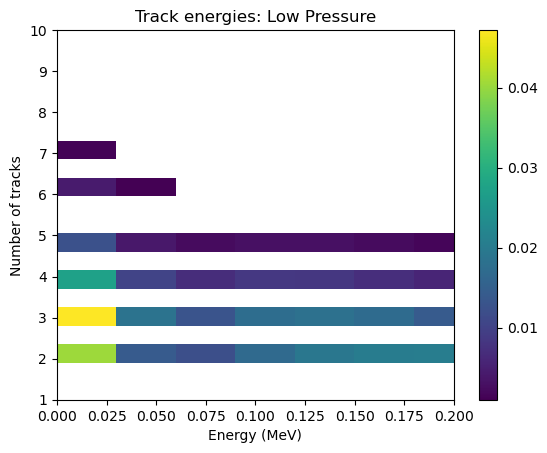

In [9]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = tracks.energy
track_no = tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 20), cmin=0.001)
plt.xlim([0,0.2])
plt.title("Track energies: Low Pressure")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.colorbar()
plt.show()

### Remove low energy events

In [10]:
def remove_low_E_events(df, energy_limit = 0.05):
    '''
    Remove low energy tracks, add their energy back to the first
    track and then update 'numb_of_tracks' to be up to date
    '''

    tracks_test = df.copy(deep=True)

    # take events with lower than 50 keV, 0.05 MeV
    condition = (tracks_test.energy < energy_limit)
    summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()

    # merge these as a new column
    merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'))

    # add this summed energy to first column
    merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)

    # drop energy sum column
    result_df = merged_df.drop('energy_sum', axis = 1)

    # then remove all tracks below the energy threshold
    condition_upper = (result_df.energy > energy_limit)
    remove_low_E = result_df[condition_upper]

    # count the number of events identified with unique event, and change numb_of_tracks to reflect this
    event_counts = remove_low_E['event'].value_counts(sort = False)

    # apply this to numb_of_tracks
    remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

    return remove_low_E

##### Cuts

We want to:
- Remove low energy events (as shown above)
- Include events within the fiducial volume [r < 472mm; 20 mm < z < 1195mm]
- only include 1-track events
- No overlapping blobs
- Energy cut for thallium [1.5, 1.7] MeV


### Low energy cut

In [11]:
# Low energy cut
display(tracks.head(10))
low_e_cut_tracks = remove_low_E_events(tracks)
display(low_e_cut_tracks.head(10))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,157.128756,65,11348,1,368.675,163.675,334.439758,...,346.677116,388.298799,273.735214,442.301561,0.591051,0.013352,0.000000,13.800000,13.900000,14.429691
1,5080002,0,2.097495,339.919849,90,13467,2,-108.325,332.675,498.257599,...,651.573556,153.314470,367.920389,502.593622,0.375646,0.151995,0.000000,14.368421,14.888889,14.403850
2,5080002,1,0.008122,14.368421,2,70,2,27.675,410.675,618.963989,...,618.963989,39.001864,416.663406,620.861787,0.008122,0.008122,0.008122,14.368421,14.888889,14.403850
3,5080004,0,0.475855,33.046321,5,4467,2,19.675,-316.325,147.604263,...,154.720772,38.507312,-310.859095,153.875947,0.406043,0.388595,0.318784,13.333333,13.833333,14.510910
4,5080004,1,0.000826,0.000000,1,28,2,36.675,-259.325,154.847458,...,154.847458,38.559927,-256.434284,154.847458,0.000826,0.000826,0.000826,13.333333,13.833333,14.510910
5,5080006,0,0.274088,24.785456,8,3088,2,94.675,450.675,723.968079,...,741.386551,101.942989,459.464765,727.760292,0.267657,0.206344,0.200691,13.875000,14.384615,14.658991
6,5080006,1,0.105957,14.384615,2,1187,2,24.675,291.675,340.766083,...,345.140332,27.855075,309.062660,343.988099,0.105957,0.105957,0.105957,13.875000,14.384615,14.658991
7,5080008,0,0.312121,24.509739,5,3112,3,210.675,206.675,251.550385,...,267.557011,216.396523,224.550690,256.918365,0.304846,0.301190,0.293916,13.750000,14.153846,14.537312
8,5080008,1,0.115869,19.733065,4,1424,3,234.675,347.675,441.530823,...,443.745212,248.684053,364.174835,443.737357,0.115869,0.115869,0.115869,13.750000,14.153846,14.537312
9,5080008,2,0.030160,14.153846,2,234,3,204.675,220.675,541.294250,...,542.296631,210.206583,225.784261,541.294250,0.030138,0.030130,0.030108,13.750000,14.153846,14.537312


/tmp/ipykernel_11158/261361389.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080002,0,2.105617,339.919849,90,13467,1,-108.325,332.675,498.257599,...,651.573556,153.314470,367.920389,502.593622,0.375646,0.151995,0.000000,14.368421,14.888889,14.403850
2,5080004,0,0.476680,33.046321,5,4467,1,19.675,-316.325,147.604263,...,154.720772,38.507312,-310.859095,153.875947,0.406043,0.388595,0.318784,13.333333,13.833333,14.510910
4,5080008,0,0.342280,24.509739,5,3112,2,210.675,206.675,251.550385,...,267.557011,216.396523,224.550690,256.918365,0.304846,0.301190,0.293916,13.750000,14.153846,14.537312
5,5080008,1,0.115869,19.733065,4,1424,2,234.675,347.675,441.530823,...,443.745212,248.684053,364.174835,443.737357,0.115869,0.115869,0.115869,13.750000,14.153846,14.537312
7,5080010,0,1.271544,78.643483,30,10336,2,-88.325,51.675,1119.816162,...,1129.047003,-52.439413,59.815238,1157.046561,0.651969,0.080360,0.000000,13.833333,14.500000,14.646083
8,5080010,1,0.142156,13.833333,2,1553,2,-89.325,356.675,578.050293,...,583.115655,-72.622450,361.062762,582.290556,0.142156,0.142156,0.142156,13.833333,14.500000,14.646083
11,5080034,0,2.355780,394.598184,133,12524,2,72.675,-40.325,331.339752,...,334.573008,209.908044,206.310408,506.522910,0.769605,0.111880,0.000000,15.000000,14.666667,14.414317
12,5080034,1,0.125304,20.803186,4,510,2,90.675,237.675,375.396118,...,377.844070,103.806299,242.419688,381.553062,0.125304,0.125304,0.125304,15.000000,14.666667,14.414317
16,5080040,0,0.316157,25.419533,6,3361,3,339.675,230.675,583.299133,...,588.369854,356.747932,248.120508,596.122986,0.308369,0.307537,0.307514,14.928571,14.181818,14.905249
17,5080040,1,0.202630,20.590925,4,2231,3,161.675,359.675,381.714417,...,386.505278,178.530785,374.692267,385.729485,0.202630,0.202630,0.202630,14.928571,14.181818,14.905249


26382


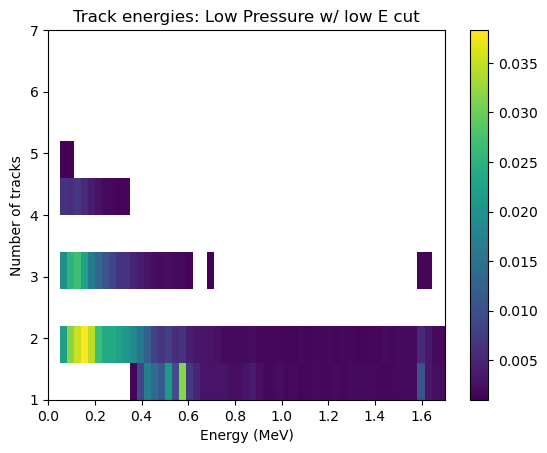

In [12]:
print(len_events(low_e_cut_tracks))

track_energy = low_e_cut_tracks.energy
track_no = low_e_cut_tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 10), cmin=0.001)
plt.title("Track energies: Low Pressure w/ low E cut")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.xlim([0,1.7])
plt.colorbar()
plt.show()

In [13]:
# Efficiency calculation
cut_names = []
rel_cut_effics = []
abs_cut_effics = []
cut_events = []

# no cuts
cut_names.append("No cuts")
rel_cut_effics.append(100)
abs_cut_effics.append(100)
# number of events
cut_events.append(len_events(tracks))


# low energy cut
cut_names.append("low E cuts")

# make efficiency calculation
print("Low E cut")
print("==================")
ef = cut_effic(low_e_cut_tracks, tracks)

# add efficiency calculation
rel_cut_effics.append(ef)
cut_events.append(len_events(low_e_cut_tracks))
abs_cut_effics.append(ef)

Low E cut
Efficiency: 26.38 %


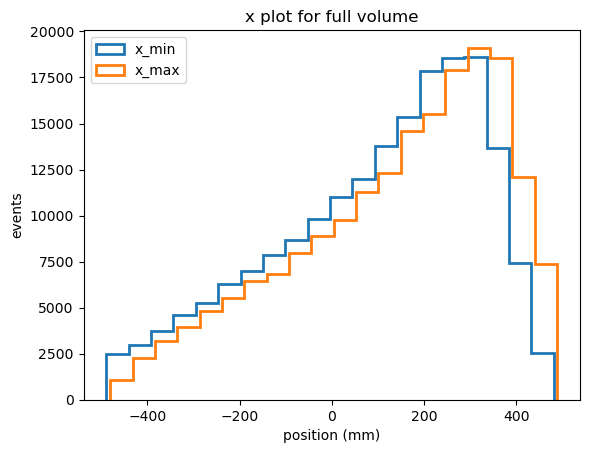

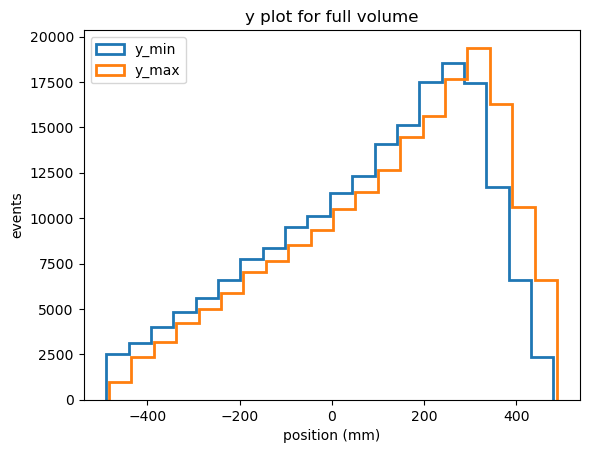

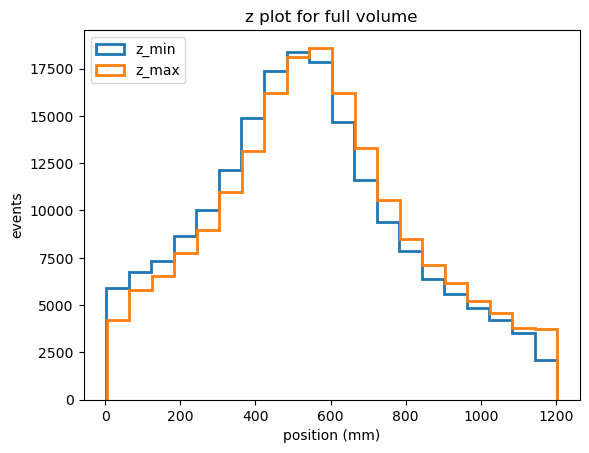

In [14]:
# plotting the positional histograms
plot_volume_hists(tracks)

# Fiducial cuts

In [15]:


cut_names.append("Fiducial Cuts")

# make fiducial cuts
fiducial_rel = fiducial_track_cut_2(low_e_cut_tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = False)

fiducial_abs = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

# make efficiency calculation
print("Fiducial track cut")
print("==================")
print("Relative Cut efficiency:")
ef = cut_effic(fiducial_rel, low_e_cut_tracks)
rel_cut_effics.append(ef)
cut_events.append(len_events(fiducial_rel))

print('Absolute Cut efficiency:')
ef = cut_effic(fiducial_abs, tracks)
abs_cut_effics.append(ef)


Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Fiducial track cut
Relative Cut efficiency:
Efficiency: 70.71 %
Absolute Cut efficiency:
Efficiency: 66.62 %


# One track cut

In [16]:
# relative

cut_names.append("One track cut")
one_track_rel = one_track_cuts(fiducial_rel, verbose = False)

# events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
one_track_abs = one_track_cuts(tracks)

## sanity check here
#print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

# relative
print("Single track cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(one_track_rel, fiducial_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(one_track_rel))

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(one_track_abs, tracks)
abs_cut_effics.append(ef)

Single track cut
Relative Cut efficiency:
Efficiency: 48.47 %
Absolute Cut efficiency:
Efficiency: 43.63 %


# Overlapping blob cuts

In [17]:
# apply cuts
ovlp_rel = overlapping_cuts(one_track_rel)
ovlp_abs = overlapping_cuts(tracks)

cut_names.append("Blob overlap cuts")

# relative
print("Blob overlap cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ovlp_rel, one_track_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ovlp_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ovlp_abs, tracks)
abs_cut_effics.append(ef)

Blob overlap cut
Relative Cut efficiency:
Efficiency: 58.24 %
Absolute Cut efficiency:
Efficiency: 56.00 %


# Energy cut

In [18]:
ecut_rel = energy_cuts(ovlp_rel)
ecut_abs = energy_cuts(tracks)

cut_names.append("Energy cuts")

# relative
print("Energy cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ecut_rel, ovlp_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ecut_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ecut_abs, tracks)
abs_cut_effics.append(ef)

Energy cut
Relative Cut efficiency:
Efficiency: 16.29 %
Absolute Cut efficiency:
Efficiency: 7.08 %


In [19]:
efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Relative Events': cut_events,
                             'Single Cut Efficiency': abs_cut_effics
                             })

display(efficiencies)
print("Single Cut Efficiency: each cut on the original unmodified data set\nRelative Efficiency: each cut efficiency wrt the previous cut")

,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,100009,100.000000
1,low E cuts,26.379626,26382,26.379626
2,Fiducial Cuts,70.711091,18655,66.615005
3,One track cut,48.474940,9043,43.626074
4,Blob overlap cuts,58.243946,5267,55.995960
5,Energy cuts,16.290108,858,7.078363


Single Cut Efficiency: each cut on the original unmodified data set
Relative Efficiency: each cut efficiency wrt the previous cut


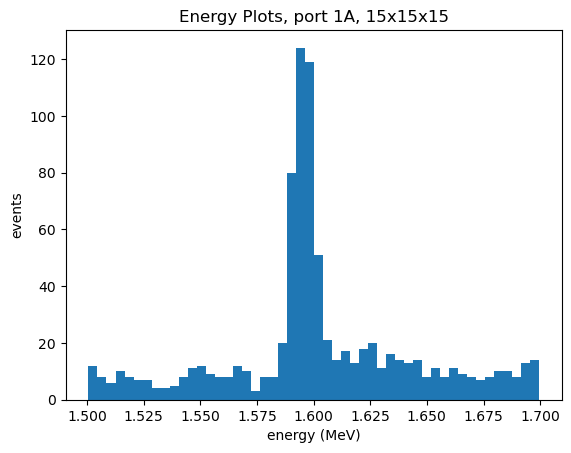

In [20]:
# just for visualising it
plot_hist(ecut_rel, binning = 50, title = 'Energy Plots, port 1A, 15x15x15')


In [21]:
# checking out some of the stranger tracks
display(low_e_cut_tracks[low_e_cut_tracks['numb_of_tracks'] == 2].head(10))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
4,5080008,0,0.342280,24.509739,5,3112,2,210.675,206.675,251.550385,...,267.557011,216.396523,224.550690,256.918365,0.304846,0.301190,0.293916,13.750000,14.153846,14.537312
5,5080008,1,0.115869,19.733065,4,1424,2,234.675,347.675,441.530823,...,443.745212,248.684053,364.174835,443.737357,0.115869,0.115869,0.115869,13.750000,14.153846,14.537312
7,5080010,0,1.271544,78.643483,30,10336,2,-88.325,51.675,1119.816162,...,1129.047003,-52.439413,59.815238,1157.046561,0.651969,0.080360,0.000000,13.833333,14.500000,14.646083
8,5080010,1,0.142156,13.833333,2,1553,2,-89.325,356.675,578.050293,...,583.115655,-72.622450,361.062762,582.290556,0.142156,0.142156,0.142156,13.833333,14.500000,14.646083
11,5080034,0,2.355780,394.598184,133,12524,2,72.675,-40.325,331.339752,...,334.573008,209.908044,206.310408,506.522910,0.769605,0.111880,0.000000,15.000000,14.666667,14.414317
12,5080034,1,0.125304,20.803186,4,510,2,90.675,237.675,375.396118,...,377.844070,103.806299,242.419688,381.553062,0.125304,0.125304,0.125304,15.000000,14.666667,14.414317
20,5080050,0,0.244963,20.441824,3,1636,2,245.675,92.675,107.699036,...,111.352312,261.868555,102.021961,111.398047,0.215051,0.215051,0.215051,14.656250,14.250000,14.499443
21,5080050,1,0.158183,14.250000,2,1728,2,-194.325,-93.325,489.836517,...,495.082517,-184.474474,-73.344645,494.284315,0.158183,0.158179,0.158179,14.656250,14.250000,14.499443
23,5080054,0,1.183965,266.563206,70,7814,2,68.675,382.675,567.532288,...,617.715984,225.992671,403.155214,587.363689,0.264730,0.085080,0.000000,15.000000,14.352941,14.247280
24,5080054,1,0.879164,90.866993,26,4517,2,128.675,394.675,494.047424,...,512.463054,141.380503,404.391583,541.910756,0.321344,0.159543,0.000000,15.000000,14.352941,14.247280


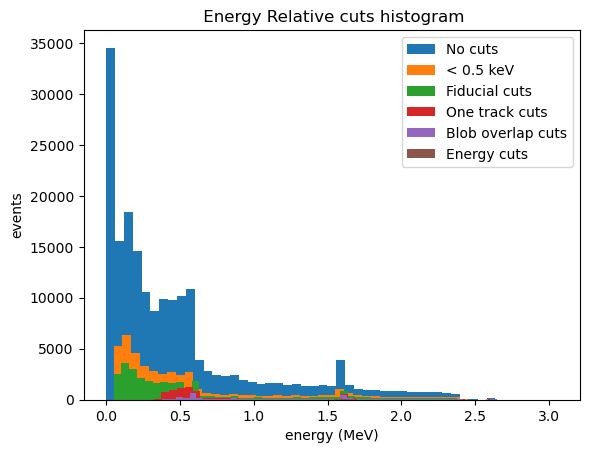

In [22]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(low_e_cut_tracks, label = '< 0.5 keV', output = False, binning = 50)
plot_hist(fiducial_rel, label = 'Fiducial cuts', output = False, binning = 50)
plot_hist(one_track_rel, label = 'One track cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'Blob overlap cuts', output = False, binning = 50)
plot_hist(ecut_rel, label = 'Energy cuts', output = False, title=' Energy Relative cuts histogram')
plt.legend()
plt.show()

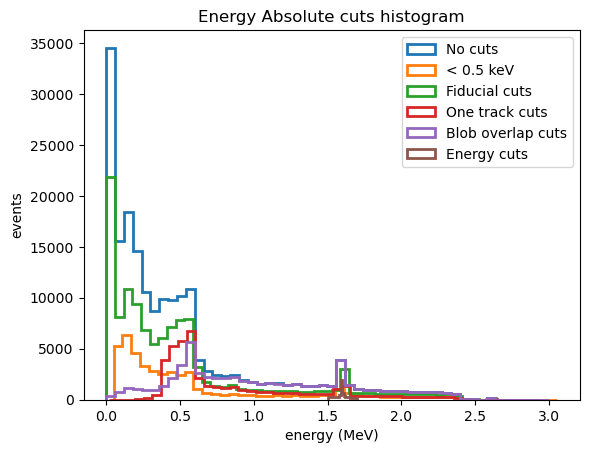

In [23]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50, fill = False)
plot_hist(low_e_cut_tracks, label = '< 0.5 keV', output = False, binning = 50, fill = False)
plot_hist(fiducial_abs, label = 'Fiducial cuts', output = False, binning = 50, fill = False)
plot_hist(one_track_abs, label = 'One track cuts', output = False, binning = 50, fill = False)
plot_hist(ovlp_abs, label = 'Blob overlap cuts', output = False, binning = 50, fill = False)
plot_hist(ecut_abs, label = 'Energy cuts', output = False, title='Energy Absolute cuts histogram', fill = False)
plt.legend()
plt.show()

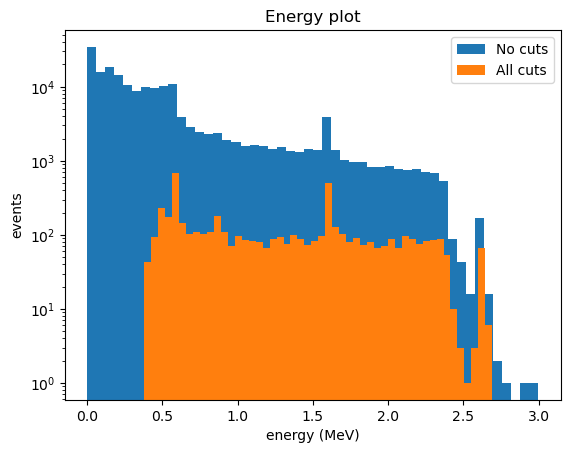

In [24]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'All cuts', output = False, binning = 50)
plt.yscale('log')
plt.legend()
plt.show()

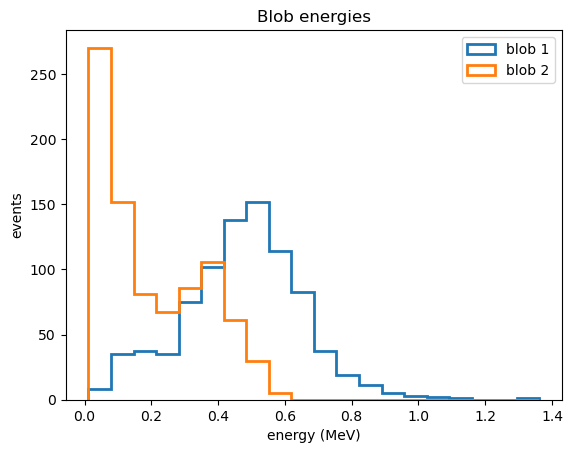

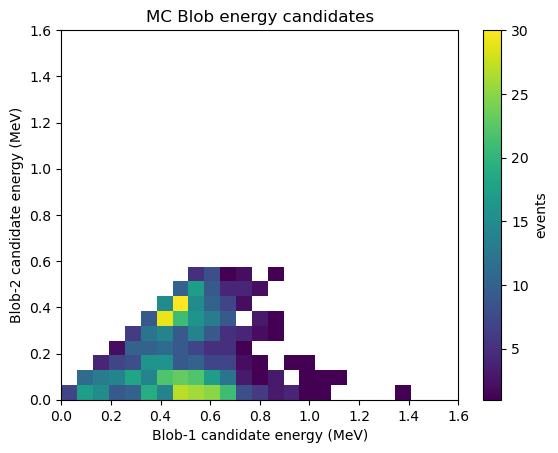

In [25]:
# plot blob energies

# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
#print(minimum_e, maximum_e)

plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(ecut_rel['eblob1'], ecut_rel['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

# Collecting all e+e- events 

In [26]:
# create e+ dataframe only
positron_df = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events = positron_df.append(particles.loc[condition], ignore_index=True)
print("True events with positrons:")
display(positron_events.head(20))

# collect events
pos_events = np.unique(positron_events['event_id'].to_numpy())
print("Total number of positron events: {}".format(len(pos_events)))
#print(pos_events)


# collect all events that dont match this list
ecut_no_positron_df = ecut_rel[~ecut_rel['event'].isin(pos_events)]

print("Isaura events with no positrons")
display(ecut_no_positron_df.head(20))

# events with positrons only in here!
ecut_positron_df = ecut_rel[ecut_rel['event'].isin(pos_events)]

print("Isaura events with positrons:")
display(ecut_positron_df.head(20))

# Check that we get all the data, should print true (which it does) 
print("Isaura events total: {}\nPositron Events: {}\nNon-positron events: {}\nDoes this add up? {}".format(len(ecut_rel),len(ecut_positron_df), len(ecut_no_positron_df), len(ecut_positron_df) + len(ecut_no_positron_df) == len(ecut_rel)))
print()

# make range full range of blob1 and blob2...
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

#...so that we can produce the min and max blob energy
minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
#print(minimum_e, maximum_e)


True events with positrons:


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
2,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
3,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
4,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
5,5080066,40,e+,False,38,427.781158,377.352051,442.963135,0.340736,428.130005,...,0.537648,-0.716717,-1.240047,-0.0,0.0,-0.0,1.101944,0.871644,conv,annihil
6,5080080,46,e+,False,38,426.655273,364.533203,592.671570,0.232653,426.677277,...,0.462149,-0.210924,0.238228,-0.0,0.0,-0.0,0.247910,0.071758,conv,annihil
7,5080136,39,e+,False,37,477.058289,-86.245613,347.050385,1.740581,374.990082,...,-1.460626,-0.183496,0.252609,0.0,-0.0,0.0,1.067617,277.627106,conv,annihil
8,5080138,38,e+,False,36,-63.345615,-213.545135,977.998840,2.941550,-61.490604,...,0.078129,-0.363009,0.665113,-0.0,-0.0,-0.0,0.406266,69.172440,conv,annihil
9,5080172,52,e+,False,50,-32.611187,216.488098,1540.216064,3.699887,-32.628563,...,-0.335066,0.032621,0.565033,0.0,0.0,0.0,0.321897,0.147108,conv,annihil


Total number of positron events: 13282
Isaura events with no positrons


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
31,5080086,0,1.682439,249.424162,80,10002,1,-243.325,-163.325,1051.574341,...,1062.511843,-220.772813,-57.187879,1058.241316,0.606683,0.021639,0.0,14.111111,14.333333,13.494176
146,5080380,0,1.524555,192.103520,59,11062,1,8.675,-246.325,88.786362,...,91.791763,87.512924,-139.048330,211.568898,0.217073,0.042457,0.0,14.500000,14.500000,13.871840
583,3580010,0,1.590124,195.704736,59,11388,1,-23.325,-48.325,1105.137695,...,1115.240556,11.526059,124.458984,1127.603201,0.757156,0.036847,0.0,13.000000,14.857143,14.063745
1049,1140496,0,1.693440,255.910928,70,13012,1,-119.325,276.675,206.399658,...,236.592676,87.969589,374.383886,258.074936,0.639715,0.094058,0.0,14.500000,13.250000,13.884201
1579,80494,0,1.582480,244.162791,78,11676,1,-169.325,191.675,361.742035,...,414.093422,15.601559,298.977827,399.017774,0.540074,0.060205,0.0,15.000000,14.266667,12.938370
1650,20046,0,1.557208,248.615824,68,12097,1,332.675,-9.325,613.732849,...,656.852721,392.021263,38.749904,692.337072,0.397573,0.249399,0.0,13.857143,15.000000,13.815542
2328,1560468,0,1.586793,75.863376,30,12639,1,181.675,28.675,1021.142090,...,1034.342168,219.956738,104.694370,1035.682868,0.643150,0.059250,0.0,14.090909,14.000000,14.171064
2457,3840108,0,1.566211,264.810211,75,12854,1,261.675,58.675,578.065430,...,610.591613,325.056440,189.543086,593.160894,0.658761,0.045604,0.0,13.900000,14.181818,12.310715
2495,3840212,0,1.558024,184.005890,68,13113,1,290.675,-208.325,384.856262,...,413.959164,396.749123,-68.737139,443.247657,0.341290,0.018252,0.0,13.500000,14.181818,12.798608
2683,3840600,0,1.504559,250.219104,67,12292,1,-17.325,-421.325,77.280083,...,81.154376,128.536396,-324.176348,112.500911,0.307559,0.073693,0.0,14.090909,15.000000,14.448921


Isaura events with positrons:


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
201,5080496,0,1.594183,149.721509,60,12933,1,147.675,-166.325,322.920868,...,348.228080,153.085963,-124.132459,333.285062,0.456853,0.451467,0.0,14.300000,13.142857,13.105713
811,3580634,0,1.639774,315.207476,76,11557,1,161.675,-179.325,380.667084,...,603.785914,202.516659,-103.641247,387.996180,0.467061,0.455991,0.0,14.750000,14.714286,14.638202
880,1140132,0,1.591198,114.950939,47,11946,1,85.675,-225.325,101.465935,...,109.540302,129.486649,-219.875674,167.802024,0.579801,0.451323,0.0,13.571429,13.571429,14.491912
937,1140258,0,1.601926,172.096063,80,11960,1,208.675,239.675,763.899841,...,837.211632,241.291973,355.510631,771.321284,0.506700,0.498815,0.0,13.714286,14.222222,13.631795
945,1140276,0,1.602210,206.668391,61,12469,1,146.675,256.675,669.404236,...,679.734808,227.933840,265.123321,759.195321,0.750460,0.298254,0.0,13.250000,13.625000,13.937186
987,1140334,0,1.596162,160.896526,60,11939,1,137.675,165.675,461.541107,...,466.735136,146.730906,217.829705,556.785972,0.393004,0.262405,0.0,14.888889,13.833333,14.537585
1165,3260128,0,1.591149,214.509101,69,12052,1,-114.325,-415.325,64.630730,...,75.105882,-11.304280,-337.355530,92.764958,0.382646,0.360392,0.0,14.200000,14.600000,13.197667
1489,80270,0,1.592333,258.604635,76,12524,1,132.675,99.675,544.458923,...,553.051486,246.794955,234.765430,609.948139,0.667734,0.137687,0.0,13.888889,14.750000,14.685364
1752,20348,0,1.594938,146.546167,81,13917,1,-308.325,92.675,161.258072,...,215.506380,-181.613964,165.776779,209.007169,0.321104,0.117530,0.0,14.909091,13.500000,14.396258
1828,20570,0,1.603397,225.232081,58,12077,1,189.675,191.675,74.125206,...,126.066638,327.848571,287.869413,91.607274,0.464391,0.380960,0.0,14.900000,14.400000,14.122656


Isaura events total: 858
Positron Events: 487
Non-positron events: 371
Does this add up? True



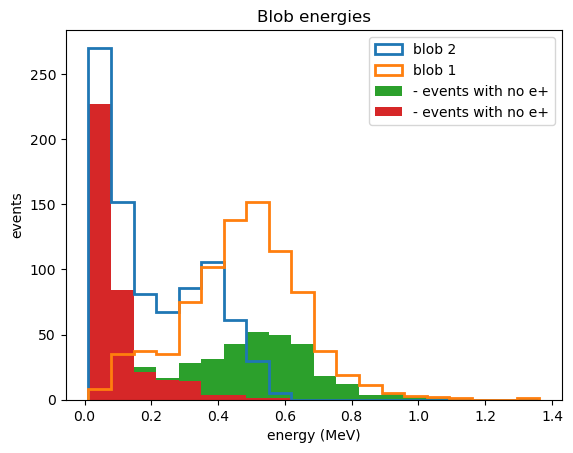

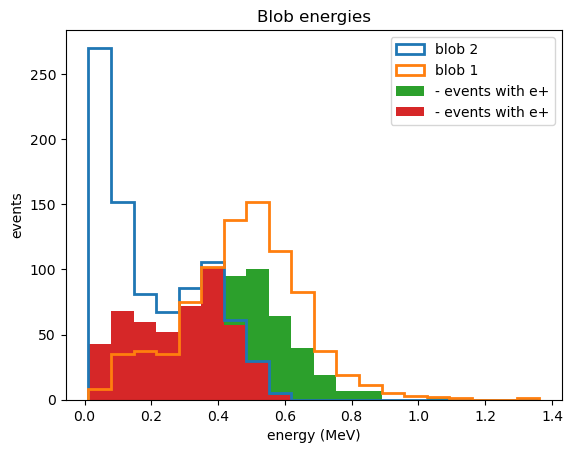

In [27]:

these_bins = 20
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_no_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_no_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

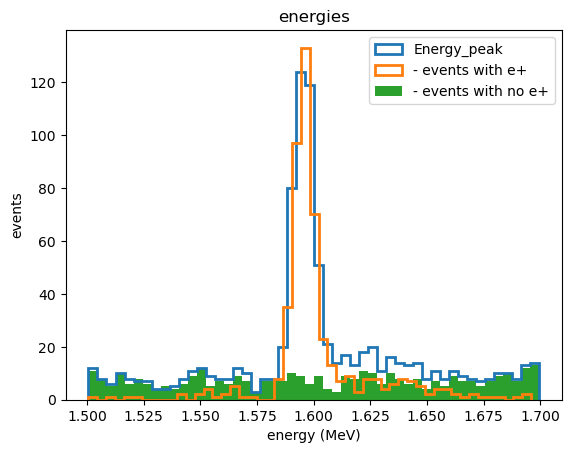

In [28]:
plot_hist(ecut_rel, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = 'Energy_peak', x_label = 'energy (MeV)')
plot_hist(ecut_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = '- events with e+', x_label = 'energy (MeV)')
plot_hist(ecut_no_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)')

plt.legend()
plt.show()

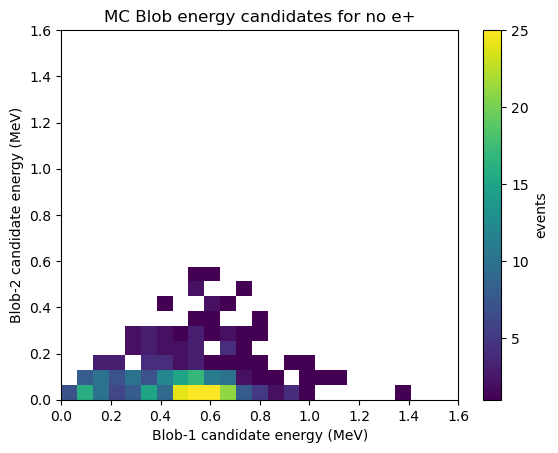

In [29]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_no_positron_df['eblob1'], ecut_no_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for no e+")
plt.show()

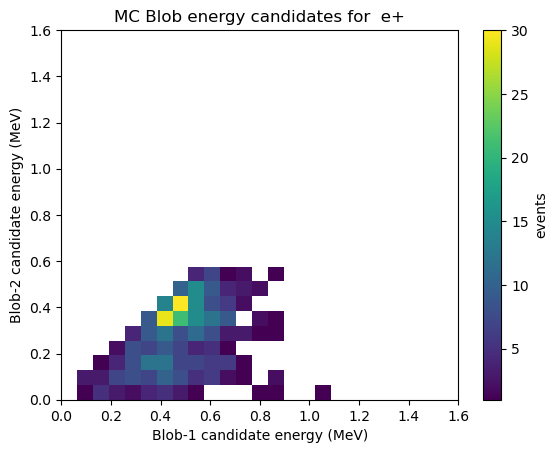

In [30]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_positron_df['eblob1'], ecut_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for  e+")
plt.show()

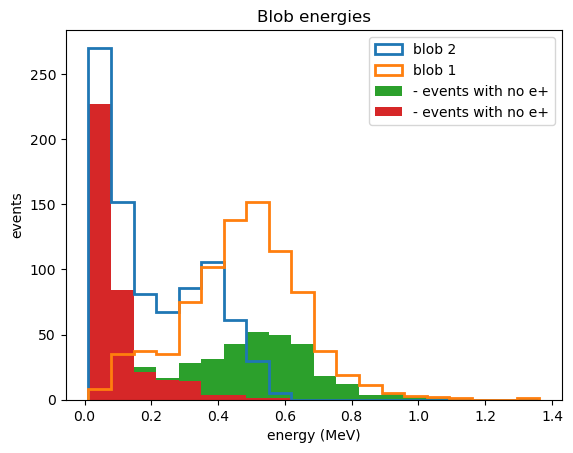

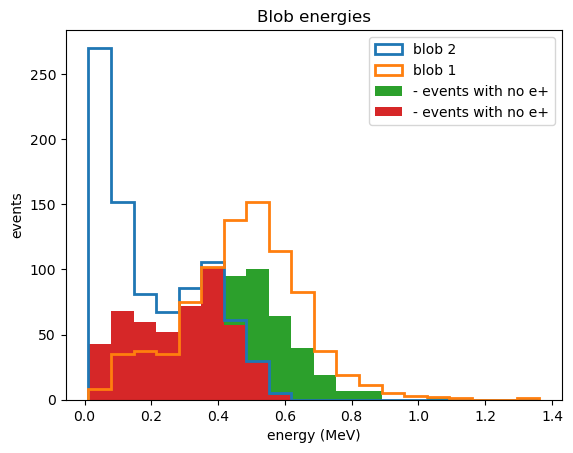

In [31]:
def blob_positron_plot(ecut_rel, ecut_no_positron_df, save = False, save_title = 'plot.png'):
    '''
    Plots the blob energies with and without positrons.
    '''

    # the original way
    plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    #plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
    #plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

    plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    plt.legend()

    if (save == True):
        plt.savefig(save_title)
    plt.show()

blob_positron_plot(ecut_rel, ecut_no_positron_df)
blob_positron_plot(ecut_rel, ecut_positron_df)

# Now to readadapt the code to give true FOM from sig and background while adjusting the cut location.

In [32]:


def true_fom_calc(p_data, no_p_data, cut_list, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    '''

    # create deep copies for safety
    pos_data = p_data.copy(deep = True)
    no_pos_data = no_p_data.copy(deep = True)

    if (verbose == True):
        blob_positron_plot(pos_data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    ns0 = len(pos_data.index)
    nb0 = len(no_pos_data.index)
    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        
        # remove blob 2 values below value on cut_list
        pos_data = pos_data[(pos_data['eblob2'] > cut_list[i])]
        no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]


        # apply fit to the new data 
        if (verbose == True):
            print("Signal events: {}\nBackground events: {}\n FOM: {}".format())
        
        # collect number of signal events vs number of backgrounds, which you know 
        ns = len(pos_data.index)
        nb = len(no_pos_data.index)

        # produce fom value
        e.append(ns/ns0)
        b.append(nb/nb0)
        fom.append(e[i]/np.sqrt(b[i]))

        if (verbose == True):
            blob_positron_plot(pos_data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom

In [33]:
cut_list = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
fom = true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

/tmp/ipykernel_11158/496507008.py:41: RuntimeWarning: invalid value encountered in double_scalars
  fom.append(e[i]/np.sqrt(b[i]))


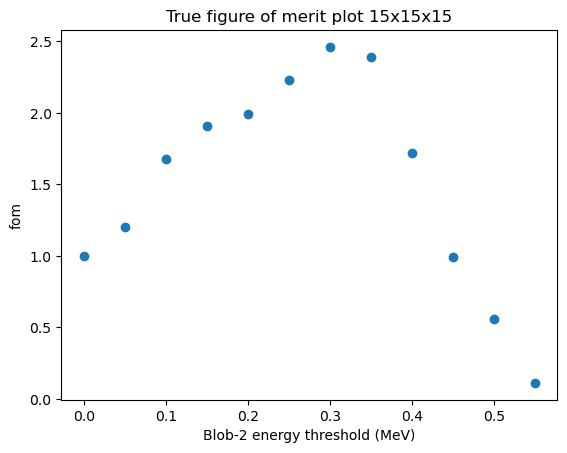

In [34]:
# plot fom
plt.scatter(cut_list, fom)
plt.title("True figure of merit plot 15x15x15")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

# save it
fom_true = fom

### Lets try a more aggressive cut around the peak to reduce FOM?

In [36]:
ecut_slim = energy_cuts(ecut_rel, lower_e = 1.575, upper_e = 1.625)


In [37]:
# create e+ dataframe only
positron_df_slim = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events_slim = positron_df.append(particles.loc[condition], ignore_index=True)
print("True events with positrons:")
display(positron_events_slim.head(20))

# collect events
pos_events_slim = np.unique(positron_events_slim['event_id'].to_numpy())
print("Total number of positron events: {}".format(len(pos_events_slim)))
#print(pos_events)


# collect all events that dont match this list
ecut_no_positron_df_slim = ecut_slim[~ecut_slim['event'].isin(pos_events_slim)]

print("Isaura events with no positrons")
display(ecut_no_positron_df_slim.head(20))

# events with positrons only in here!
ecut_positron_df_slim = ecut_slim[ecut_slim['event'].isin(pos_events_slim)]

print("Isaura events with positrons:")
display(ecut_positron_df_slim.head(20))

# Check that we get all the data, should print true (which it does) 
print("Isaura events total: {}\nPositron Events: {}\nNon-positron events: {}\nDoes this add up? {}".format(len(ecut_slim),len(ecut_positron_df_slim), len(ecut_no_positron_df_slim), len(ecut_positron_df_slim) + len(ecut_no_positron_df_slim) == len(ecut_slim)))
print()



True events with positrons:


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
2,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
3,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
4,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
5,5080066,40,e+,False,38,427.781158,377.352051,442.963135,0.340736,428.130005,...,0.537648,-0.716717,-1.240047,-0.0,0.0,-0.0,1.101944,0.871644,conv,annihil
6,5080080,46,e+,False,38,426.655273,364.533203,592.671570,0.232653,426.677277,...,0.462149,-0.210924,0.238228,-0.0,0.0,-0.0,0.247910,0.071758,conv,annihil
7,5080136,39,e+,False,37,477.058289,-86.245613,347.050385,1.740581,374.990082,...,-1.460626,-0.183496,0.252609,0.0,-0.0,0.0,1.067617,277.627106,conv,annihil
8,5080138,38,e+,False,36,-63.345615,-213.545135,977.998840,2.941550,-61.490604,...,0.078129,-0.363009,0.665113,-0.0,-0.0,-0.0,0.406266,69.172440,conv,annihil
9,5080172,52,e+,False,50,-32.611187,216.488098,1540.216064,3.699887,-32.628563,...,-0.335066,0.032621,0.565033,0.0,0.0,0.0,0.321897,0.147108,conv,annihil


Total number of positron events: 13282
Isaura events with no positrons


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
583,3580010,0,1.590124,195.704736,59,11388,1,-23.325,-48.325,1105.137695,...,1115.240556,11.526059,124.458984,1127.603201,0.757156,0.036847,0.0,13.000000,14.857143,14.063745
1579,80494,0,1.582480,244.162791,78,11676,1,-169.325,191.675,361.742035,...,414.093422,15.601559,298.977827,399.017774,0.540074,0.060205,0.0,15.000000,14.266667,12.938370
2328,1560468,0,1.586793,75.863376,30,12639,1,181.675,28.675,1021.142090,...,1034.342168,219.956738,104.694370,1035.682868,0.643150,0.059250,0.0,14.090909,14.000000,14.171064
3496,2020414,0,1.592122,302.250033,79,12844,1,88.675,-254.325,111.903679,...,116.611744,206.959173,-38.013768,240.115262,0.563205,0.089331,0.0,14.333333,14.125000,14.915805
5282,2520328,0,1.596208,239.089070,81,12721,1,144.675,300.675,119.247154,...,147.304648,198.489555,405.432937,203.033047,0.448939,0.035296,0.0,14.625000,14.200000,13.326500
5787,940286,0,1.605767,153.024856,82,11204,1,-294.325,-374.325,789.088135,...,797.570547,-278.406171,-366.762461,864.687494,0.568593,0.192581,0.0,14.277778,14.466667,14.241098
6389,2700520,0,1.593129,158.805729,64,12599,1,-87.325,159.675,636.873352,...,644.604661,-78.583676,236.116099,698.629544,0.698516,0.027222,0.0,13.750000,14.571429,13.284770
6792,4800210,0,1.587650,139.881379,78,12311,1,-141.325,336.675,665.205811,...,715.710345,-120.202894,346.582283,674.815387,0.133640,0.111712,0.0,14.583333,14.375000,12.165247
8309,4820578,0,1.599064,173.938875,54,12725,1,92.675,266.675,659.927246,...,678.894429,93.524405,367.115537,677.545446,0.100213,0.012848,0.0,14.958333,14.869565,13.375839
8985,5340624,0,1.624917,249.371413,82,11561,1,-166.325,98.675,386.989838,...,449.124127,-69.007437,150.298431,390.344773,0.737450,0.081134,0.0,13.750000,14.100000,14.587744


Isaura events with positrons:


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
201,5080496,0,1.594183,149.721509,60,12933,1,147.675,-166.325,322.920868,...,348.228080,153.085963,-124.132459,333.285062,0.456853,0.451467,0.0,14.300000,13.142857,13.105713
880,1140132,0,1.591198,114.950939,47,11946,1,85.675,-225.325,101.465935,...,109.540302,129.486649,-219.875674,167.802024,0.579801,0.451323,0.0,13.571429,13.571429,14.491912
937,1140258,0,1.601926,172.096063,80,11960,1,208.675,239.675,763.899841,...,837.211632,241.291973,355.510631,771.321284,0.506700,0.498815,0.0,13.714286,14.222222,13.631795
945,1140276,0,1.602210,206.668391,61,12469,1,146.675,256.675,669.404236,...,679.734808,227.933840,265.123321,759.195321,0.750460,0.298254,0.0,13.250000,13.625000,13.937186
987,1140334,0,1.596162,160.896526,60,11939,1,137.675,165.675,461.541107,...,466.735136,146.730906,217.829705,556.785972,0.393004,0.262405,0.0,14.888889,13.833333,14.537585
1165,3260128,0,1.591149,214.509101,69,12052,1,-114.325,-415.325,64.630730,...,75.105882,-11.304280,-337.355530,92.764958,0.382646,0.360392,0.0,14.200000,14.600000,13.197667
1489,80270,0,1.592333,258.604635,76,12524,1,132.675,99.675,544.458923,...,553.051486,246.794955,234.765430,609.948139,0.667734,0.137687,0.0,13.888889,14.750000,14.685364
1752,20348,0,1.594938,146.546167,81,13917,1,-308.325,92.675,161.258072,...,215.506380,-181.613964,165.776779,209.007169,0.321104,0.117530,0.0,14.909091,13.500000,14.396258
1828,20570,0,1.603397,225.232081,58,12077,1,189.675,191.675,74.125206,...,126.066638,327.848571,287.869413,91.607274,0.464391,0.380960,0.0,14.900000,14.400000,14.122656
2341,1560512,0,1.590812,202.454322,49,12484,1,-73.325,90.675,111.922157,...,141.929077,-60.820847,100.912823,131.127304,0.421821,0.271888,0.0,14.642857,15.000000,12.544635


Isaura events total: 500
Positron Events: 405
Non-positron events: 95
Does this add up? True



In [38]:
cut_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fom_slim = true_fom_calc(ecut_positron_df_slim, ecut_no_positron_df_slim, cut_list)

/tmp/ipykernel_5337/496507008.py:41: RuntimeWarning: invalid value encountered in double_scalars
  fom.append(e[i]/np.sqrt(b[i]))


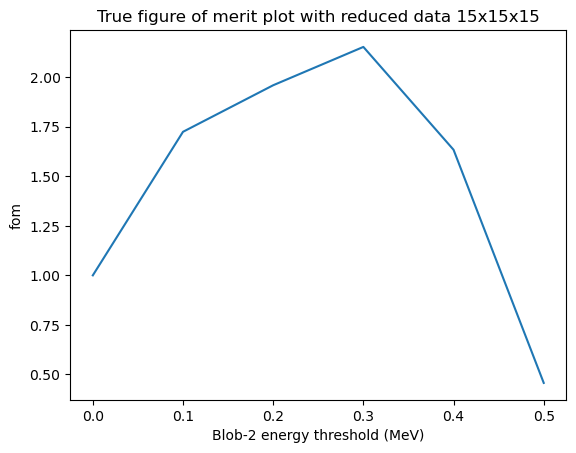

In [39]:
# plot fom
plt.plot(cut_list, fom_slim)
plt.title("True figure of merit plot with reduced data 15x15x15")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

Reducing the range makes it worse. Should have expected this in all honesty...

### Applying fitting

In [36]:
# lets try this ourselves

def bck_func(x, nb, tau):
    '''
    Function describing the background, an exponential with scaling from Nb and tau
    '''

    return nb*np.exp(-x/tau)



def skewnorm_func(x, a, mu, sigma):
    return skewnorm.pdf(x, a, loc = mu, scale = sigma)



def error_func(x, mu, sigma):
    pas = (x - mu)/(np.sqrt(2)*sigma)
    return special.erfc(pas)



def sig_func(x, ns, a, mu, sigma, C1, C2):
    
    return ns * (skewnorm_func(x, a, mu, sigma) + C1*error_func(x, mu, sigma) + C2)



def sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau):

    return bck_func(x, nb, tau) + sig_func(x, ns, a, mu, sigma, C1, C2)


# create gaussian initially for testing purposes
def gauss(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return a*np.exp(-numer/denom)


def gauss_norm(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)
    norm = (np.sqrt(2*np.pi) * sigma)


    return (a*np.exp(-numer/denom))/ norm

def gauss_bck_norm(x, a, mu, sigma, C):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)
    norm = (np.sqrt(2*np.pi) * sigma)

    return (a*np.exp(-numer/denom) / norm) + C    


def bck(x, C):
    return np.full_like(x, C)

def gauss_bck(x, a, mu, sigma, C):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)


    return a*np.exp(-numer/denom) + C

# and a print function
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0

 
# plot parameters for fit, similar to plot_hist
def plot_fit(function, x, popt, popt_label, output = False, colour = 'red', x_counts = 100000, lgnd = 'Fit', popt_text = True):
    '''
    plots a fit based on individual points and a function
    plots across a more continuous space, to reduce weird artifacting for low X numbers
    '''

    # take much more continuous x axis
    x_min = np.min(x)
    x_max = np.max(x)

    x_plot = np.linspace(x_min, x_max, num = x_counts, endpoint = True)

    y = function(x_plot, *popt)
    plt.plot(x_plot, y, label = lgnd, color = colour)
    
    # create locations to put the text relative to the scale of the figure
    percentage_hor = 0.01
    percentage_vert = 0.95
    x_loc = np.min(x) + (np.max(x) - np.min(x))*percentage_hor
    y_loc = np.min(y) + (np.max(y) - np.min(y))*percentage_vert
    # reasonable gap for separation, based on scale
    gap = (np.max(y) - np.min(y)) * 0.05

    if (popt_text == False):
        for i in range(len(popt)):

            plt.text(x_loc, y_loc - gap*i, str(popt_label[i]) + ": " + str(round(popt[i], 5)), verticalalignment='top', horizontalalignment='left')

    if (output == True):
        plt.show()
    else:
        return


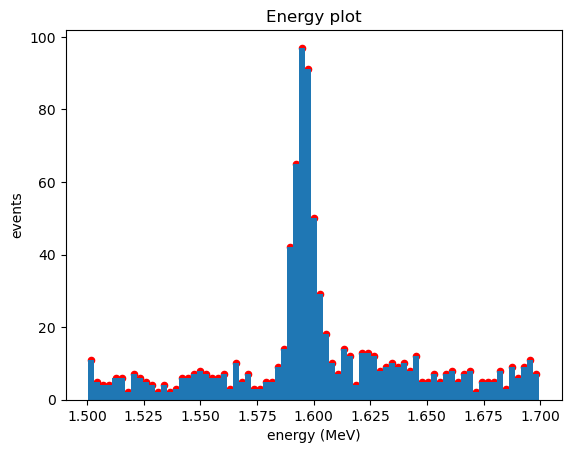

In [37]:
# try fitting gaussian
evalues = ecut_rel['energy'].to_numpy()

e_low = np.min(evalues) 
e_high = np.max(evalues)

# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 75, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)

plt.scatter(centres, hist, color='red', s = 20)
plt.show()

In [44]:
# fit gaussian to this

# p0 is the initial guesses
p0 = ([800, 1.58, 0.04])
gauss_labels = ['a', 'mu','sigma']

popt, pcov = curve_fit(gauss, centres, hist, p0, maxfev = 500000)

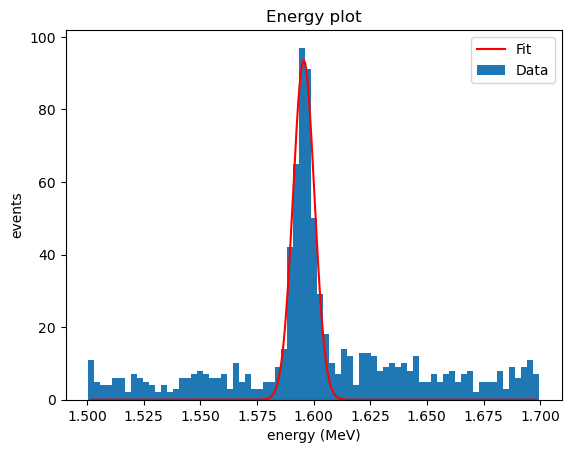

[9.34770068e+01 1.59565310e+00 4.70093448e-03]
(1.1014858675059107, 8.027107876738327e-09)
        Fitting output      
a: 93.4770 ± 4.9635
mu: 1.5957 ± 0.0003
sigma: 0.0047 ± 0.0003


In [45]:
plot_fit(gauss, centres, popt, gauss_labels)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()

print(popt)
print(quad(gauss, emin, emax, args = (popt[0], popt[1], popt[2])))

nothing = print_parameters(popt, pcov, gauss_labels)
del nothing

#### Try fitting it all now

In [46]:
# fit full thing to this

# ns -> take as fraction of peak. Example: peak at 1000 events, ns at 1000*8

# p0 is the initial guesses
p1 = ([5, -2.8, 1.6, 0.006, 0.05, 0.0001, 10, 300])
big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2', 'nb', 'tau']

popt, pcov = curve_fit(sig_bck_func, centres, hist, p1, maxfev = 500000)

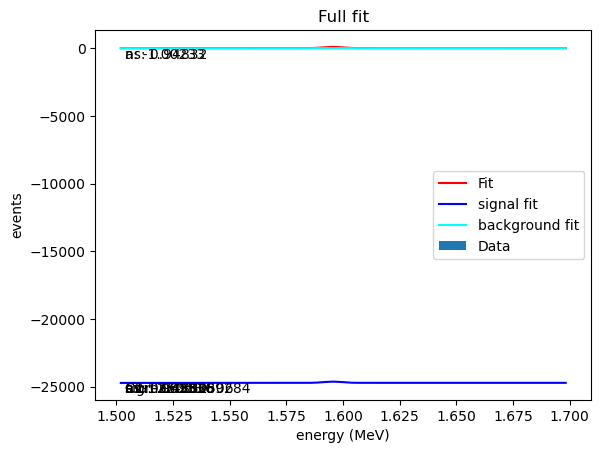

        Fitting output      
ns: 0.9483 ± 0.0249
a: -1.0023 ± 0.4003
mu: 1.5982 ± 0.0008
sigma: 0.0051 ± 0.0006
C1: -3.4554 ± 0.8824
C2: -26058.8928 ± 38890448.5592
nb: 24777.2236 ± 36880649.1121
tau: 719.1942 ± 1072898.9766


0

In [47]:
plot_fit(sig_bck_func, centres, popt, big_labels)
plot_fit(sig_func, centres, popt[:-2], big_labels[:-2], lgnd='signal fit', colour = 'blue', popt_text = False)
plot_fit(bck_func, centres, popt[:2], big_labels[:2], lgnd='background fit', colour = 'cyan', popt_text = False)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()
print_parameters(popt, pcov, big_labels)



#### Cut @ 0.2 MeV for blob 2 and see how the fit looks

In [48]:
ecut_200keV = ecut_rel[(ecut_rel['eblob2'] > 0.2)]


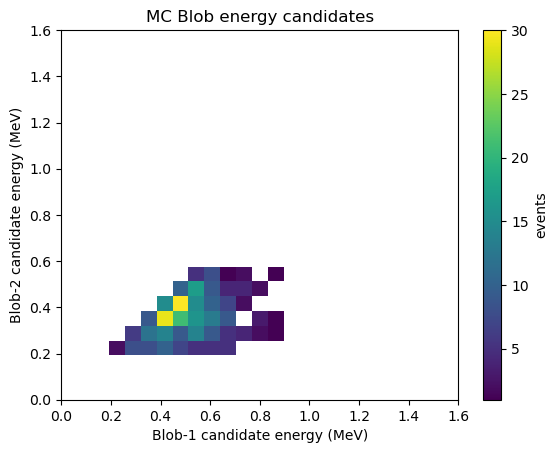

In [49]:
plt.hist2d(ecut_200keV['eblob1'], ecut_200keV['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

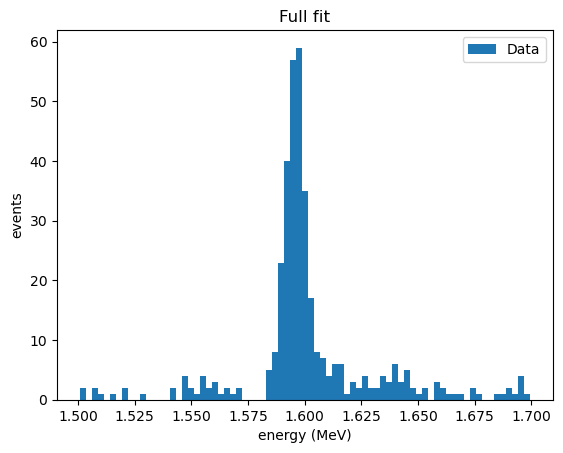

In [50]:
plot_hist(ecut_200keV, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()

### trying gauss with basic background, and then a FOM for this up to 0.2 MeV

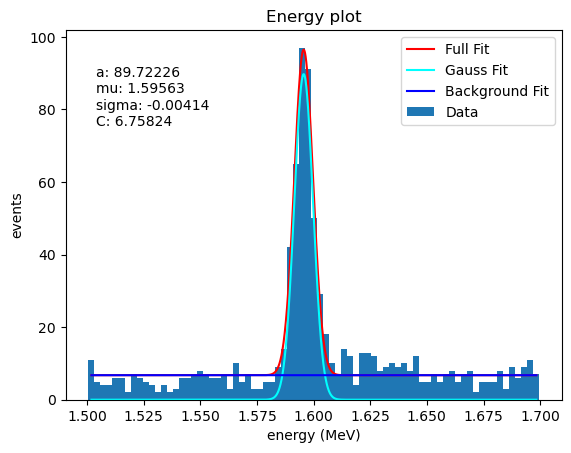

        Fitting output      
a: 89.7223 ± 2.3400
mu: 1.5956 ± 0.0001
sigma: -0.0041 ± 0.0001
C: 6.7582 ± 0.3865
ns = 351.132063897691
nb = 509.46021735179534
total = 860.5922812494864


In [51]:
# first, lets try fitting it
p0 = [1, 1.58, 0.006, 5]
gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

popt, pcov = curve_fit(gauss_bck, centres, hist, p0, maxfev = 5000000)

plot_fit(gauss_bck, centres, popt, gauss_bck_labels, lgnd='Full Fit', colour = 'red', popt_text = False)
plot_fit(gauss, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = True)
plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_bck_labels)

bin_width = centres[1] - centres[0]

x_points = np.linspace(emin, emax, 100000)

ns0 = quad(gauss, emin, emax, args = (popt[0], popt[1], popt[2]))/bin_width
nb0 = quad(bck, emin, emax, args = popt[-1])/bin_width
print('ns = {}'.format(ns0[0]))
print('nb = {}'.format(nb0[0]))
print("total = {}".format(ns0[0]+nb0[0]))

In [50]:
len(ecut_rel)

858

### So we can see from above that this works as expected (get approximately the same number of events as we wish)

In [51]:
# integrate over these functions now

print(list(popt[:-1]))
ns0 = quad(gauss, emin, emax, args = tuple(popt[:-1]))
nb0 = quad(bck, emin, emax, args = popt[-1])

print(ns0)
print(nb0)

[89.72226089760451, 1.5956337756986405, -0.004142224383242165]
(0.9315877385462923, 1.0942264263462191e-08)
(1.3516478287222078, 1.500630540631995e-14)


### Re-using old code to apply FOM cuts here

In [52]:
def default_fit(data, bins = 75, verbose = False):
    '''
    Apply the expected fit to the data here,
    '''

    # find minima and maxima
    evalues = data['energy'].to_numpy()
    e_low = np.min(evalues) 
    e_high = np.max(evalues)

    # collect heights from histogram of energy
    hist, edges, patches = plot_hist(data, binning = bins, output = False, data = True)
    plt.clf()
    # convert edges to centres
    centres = shift_to_bin_centers(edges)


    # collect assumptions
    p1 = [1, 1.58, 0.006, 5]
    gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

    # fit function
    popt, pcov = curve_fit(gauss_bck, centres, hist, p1, maxfev = 5000000)

    if (verbose == True):
        plot_fit(gauss_bck, centres, popt, gauss_bck_labels)
        plot_fit(gauss, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = False)
        plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
        
        plot_hist(data, binning = bins, output = False, data = True, label='Data')
        plt.legend()
        plt.show()
        print_parameters(popt, pcov, gauss_bck_labels)

    # centres passed through to ensure we get the correct even numbers
    return (popt, pcov, gauss_bck_labels, centres)
        



def fom_calc(data, cut_list, no_pos_data = pd.DataFrame({'A' : []}), binning = 75, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    no_pos_data related to data with no positrons in it (background).
    Useful to visualise for 
    '''

    if ((verbose == True) and not (no_pos_data.empty)):
        blob_positron_plot(data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    output = default_fit(data, bins = binning, verbose = True)

    popt = output[0]
    pcov = output[1]
    gauss_bck_labels = output[2]
    centres = output[3]

    # take bin widths to calculate number of events
    bin_width = centres[1] - centres[0]

    # signal is integration of function over the space
    ns0 = quad(gauss, emin, emax, args = tuple(popt[:-1]))/bin_width
    nb0 = quad(bck, emin, emax, args = popt[-1])/bin_width

    if (verbose == True):
        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(data.index)))


    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        print("")
        print("")
        print("")
        
        print("==========================")
        print("        CUT {} MeV       ".format(cut_list[i]))
        print("==========================")
        # remove blob 2 values below value on cut_list
        data = data[(data['eblob2'] > cut_list[i])]
        if not (no_pos_data.empty):
            no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]
        # apply fit to the new data 
        if (verbose == True):
            output = default_fit(data, bins = binning, verbose = True)
        else:
            output = default_fit(data, bins = binning, verbose = False)
        
        # collect values
        popt = output[0]
        pcov = output[1]
        gauss_bck_labels = output[2]
        centres = output[3]

        # take bin widths to calculate number of events
        bin_width = centres[1] - centres[0]

        # collect ns and nb
        ns = quad(gauss, emin, emax, args = tuple(popt[:-1]))/bin_width
        nb = quad(bck, emin, emax, args = popt[-1])/bin_width

        if (verbose == True):
            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb[0]))
            print("total = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(data.index)))
        # produce fom value (DISCREETLY NOW AS IT ISNT WORKING)
        e_check     = ns[0]/ns0[0]
        b_check     = nb[0]/nb0[0]
        fom_check   = e_check/np.sqrt(b_check)
        

        print('\ne_i: {}\nb_i: {}\nfom: {}'.format(e_check, b_check, fom_check))

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        if ((verbose == True) and not (no_pos_data.empty)):
            blob_positron_plot(data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom






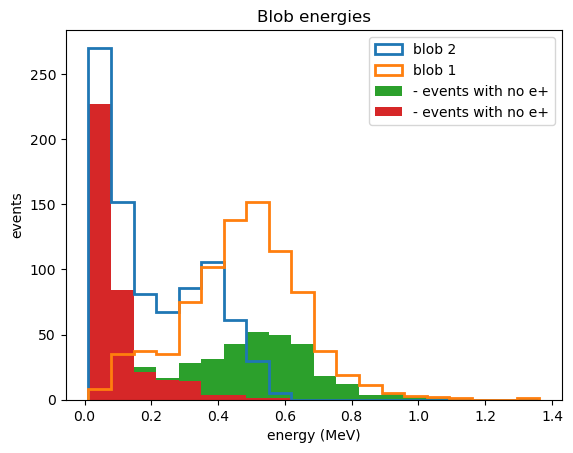

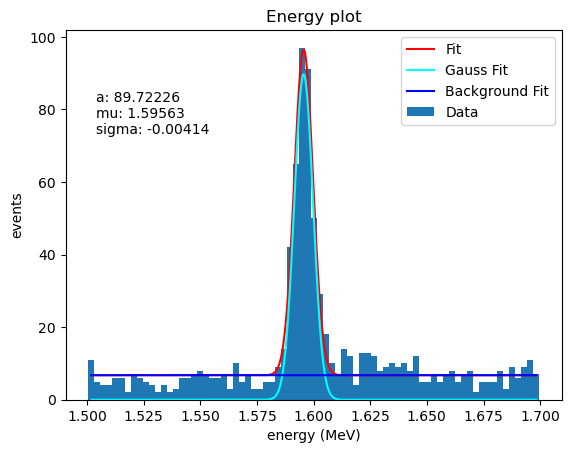

        Fitting output      
a: 89.7223 ± 2.3400
mu: 1.5956 ± 0.0001
sigma: -0.0041 ± 0.0001
C: 6.7582 ± 0.3865
ns0      = 351.132063897691
nb0      = 509.46021735179534
total    = 861
Event no = 858



        CUT 0 MeV       


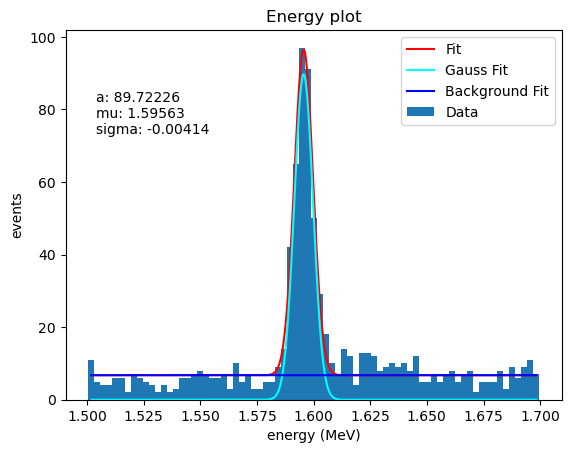

        Fitting output      
a: 89.7223 ± 2.3400
mu: 1.5956 ± 0.0001
sigma: -0.0041 ± 0.0001
C: 6.7582 ± 0.3865
ns - 351.132063897691
nb - 509.46021735179534
total = 861
Event no = 858

e_i: 1.0
b_i: 1.0
fom: 1.0


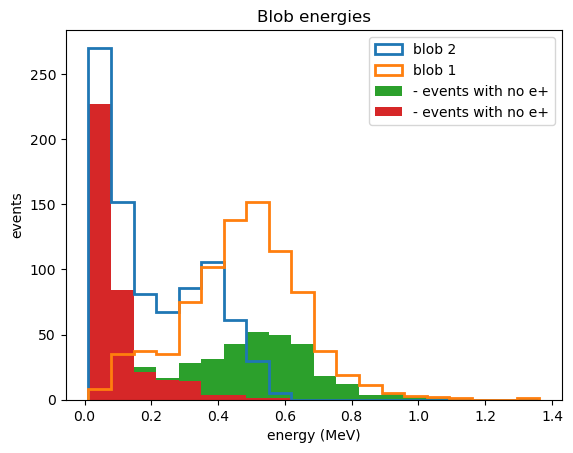




        CUT 0.05 MeV       


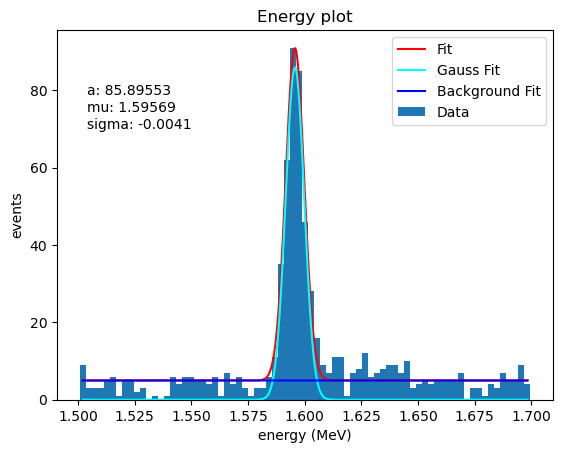

        Fitting output      
a: 85.8955 ± 2.2379
mu: 1.5957 ± 0.0001
sigma: -0.0041 ± 0.0001
C: 4.9758 ± 0.3676
ns - 332.8159675192166
nb - 375.09261297246024
total = 708
Event no = 706

e_i: 0.9478370155799524
b_i: 0.7362549620109968
fom: 1.104636902812951


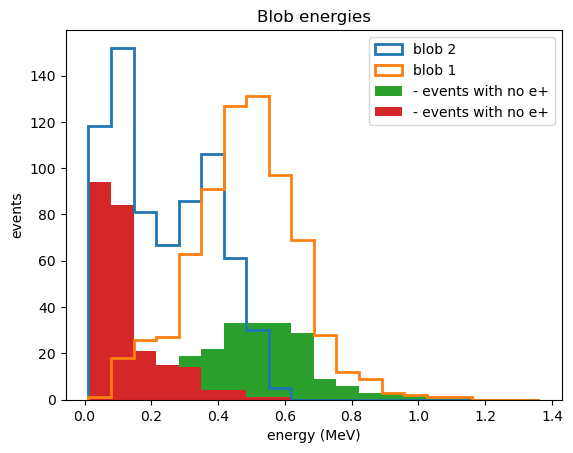




        CUT 0.1 MeV       


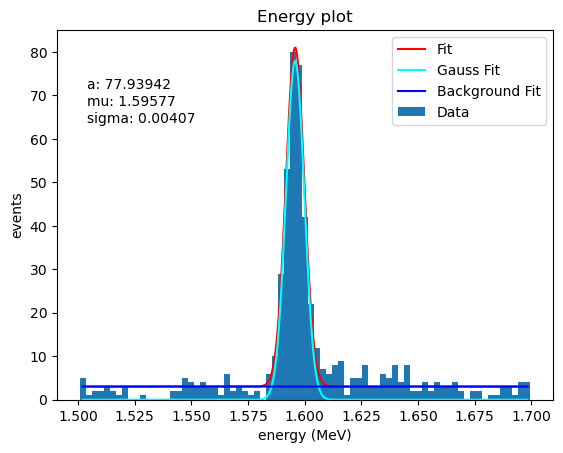

        Fitting output      
a: 77.9394 ± 1.7742
mu: 1.5958 ± 0.0001
sigma: 0.0041 ± 0.0001
C: 3.0293 ± 0.2903
ns - 299.8013544975989
nb - 228.36061022486854
total = 528
Event no = 527

e_i: 0.8538136653477243
b_i: 0.44824031876698955
fom: 1.2752861474807295


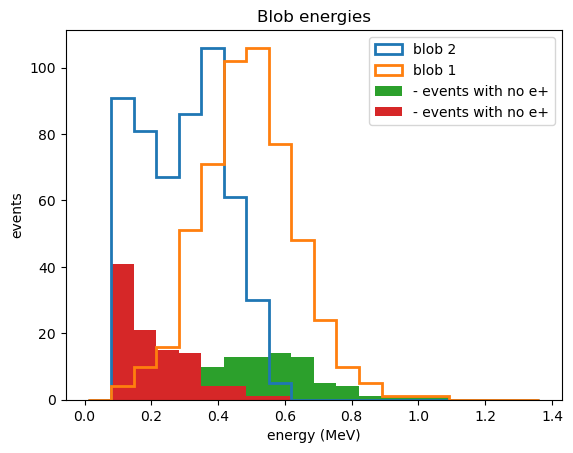




        CUT 0.15 MeV       


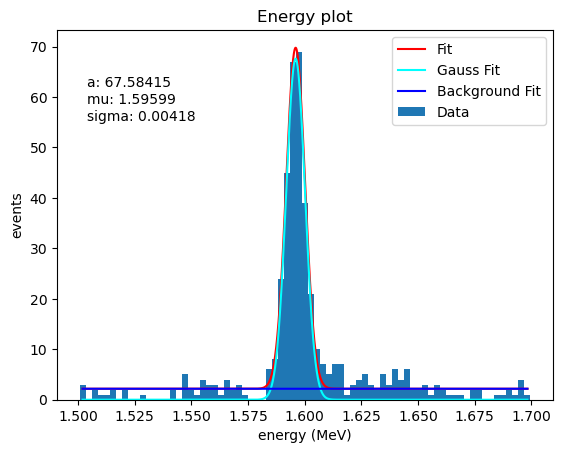

        Fitting output      
a: 67.5842 ± 1.4865
mu: 1.5960 ± 0.0001
sigma: 0.0042 ± 0.0001
C: 2.1742 ± 0.2468
ns - 266.93578470303856
nb - 163.8981749353111
total = 431
Event no = 430

e_i: 0.76021477998892
b_i: 0.3217094669084538
fom: 1.3403073164861299


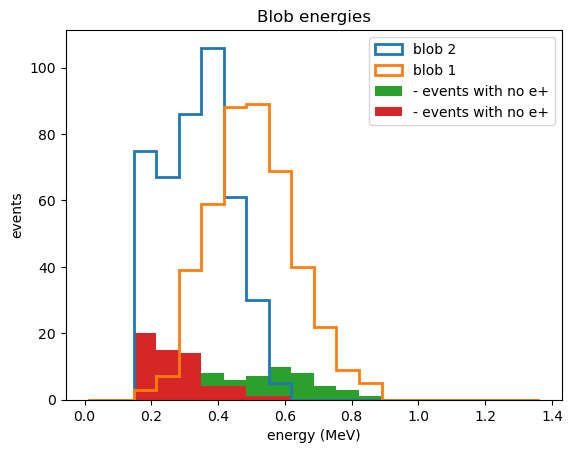




        CUT 0.2 MeV       


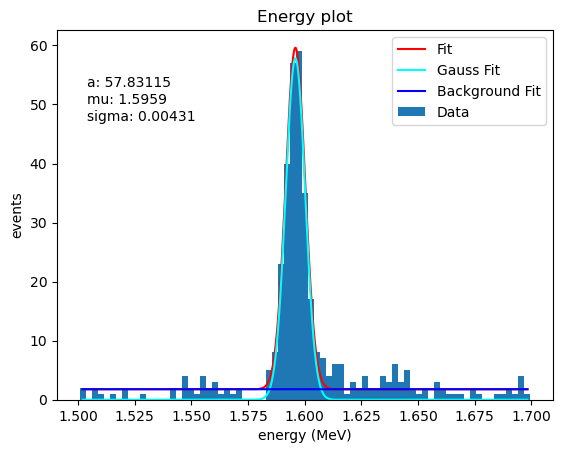

        Fitting output      
a: 57.8311 ± 1.2616
mu: 1.5959 ± 0.0001
sigma: 0.0043 ± 0.0001
C: 1.7767 ± 0.2132
ns - 235.75017595487324
nb - 133.9313055148948
total = 370
Event no = 369

e_i: 0.6714003082998524
b_i: 0.26288864361397585
fom: 1.309470212064622


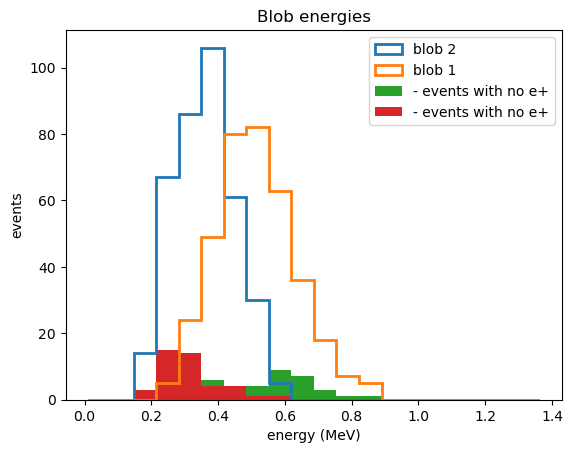




        CUT 0.25 MeV       


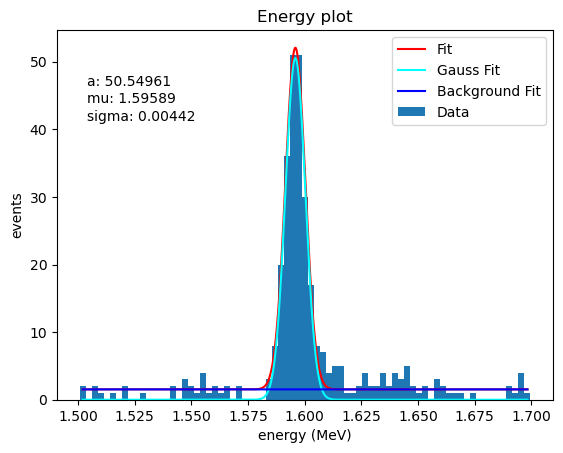

        Fitting output      
a: 50.5496 ± 1.1353
mu: 1.5959 ± 0.0001
sigma: 0.0044 ± 0.0001
C: 1.5302 ± 0.1945
ns - 211.23221392274414
nb - 115.35474459443675
total = 327
Event no = 326

e_i: 0.6015748364817252
b_i: 0.22642542178083622
fom: 1.2642328443874284


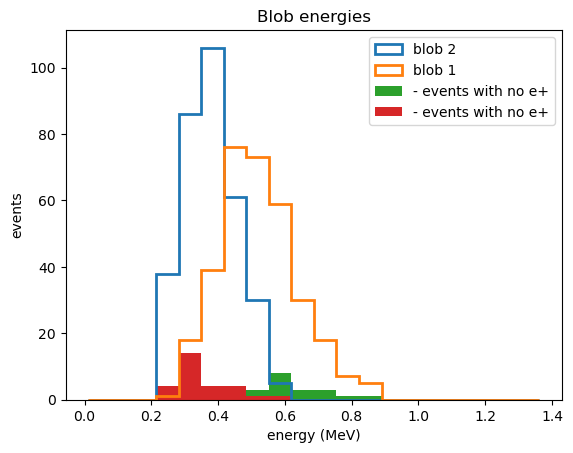




        CUT 0.3 MeV       


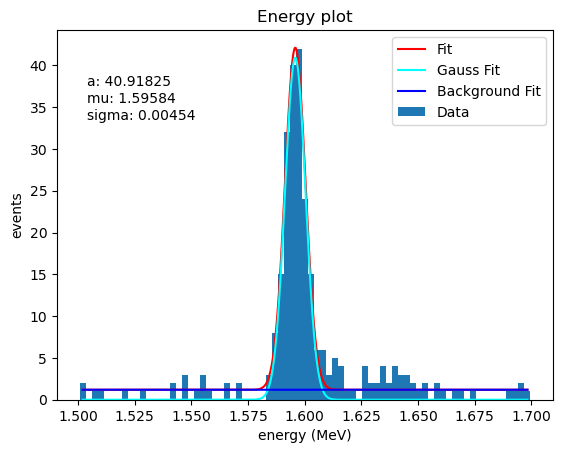

        Fitting output      
a: 40.9183 ± 1.0289
mu: 1.5958 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 1.1934 ± 0.1788
ns - 175.49324975109528
nb - 89.9645155492186
total = 265
Event no = 265

e_i: 0.499792721299951
b_i: 0.17658791105782418
fom: 1.1893493579458427


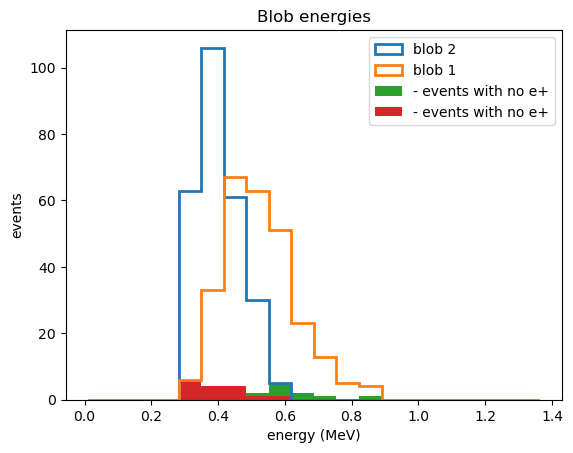




        CUT 0.35 MeV       


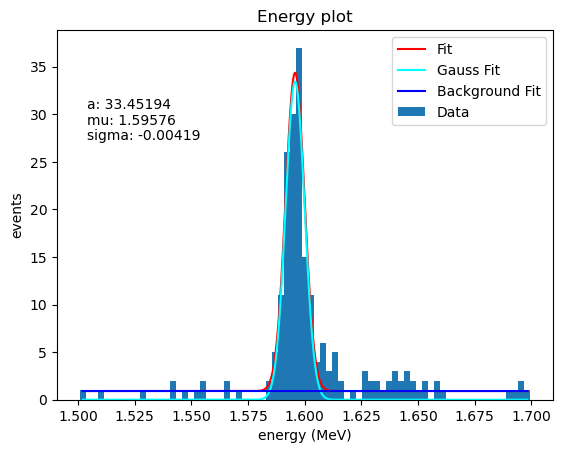

        Fitting output      
a: 33.4519 ± 1.1656
mu: 1.5958 ± 0.0002
sigma: -0.0042 ± 0.0002
C: 0.9142 ± 0.1938
ns - 132.43562019006717
nb - 68.91503813721067
total = 201
Event no = 201

e_i: 0.3771675497816537
b_i: 0.13527069590523705
fom: 1.0254924287616036


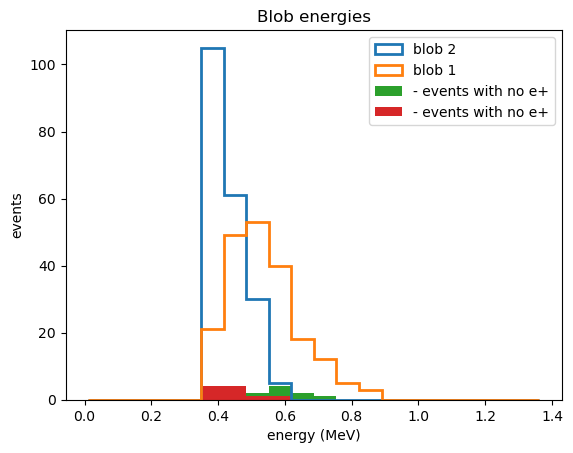




        CUT 0.4 MeV       


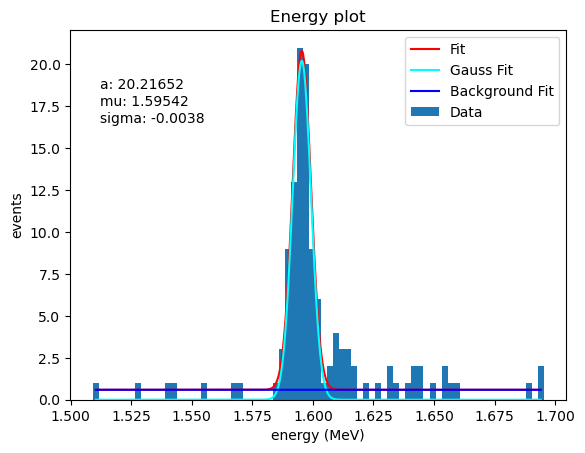

        Fitting output      
a: 20.2165 ± 0.7399
mu: 1.5954 ± 0.0002
sigma: -0.0038 ± 0.0002
C: 0.5929 ± 0.1209
ns - 77.53334466872397
nb - 47.76744015588029
total = 125
Event no = 122

e_i: 0.22080964013390353
b_i: 0.09376088363519
fom: 0.7211194078992933


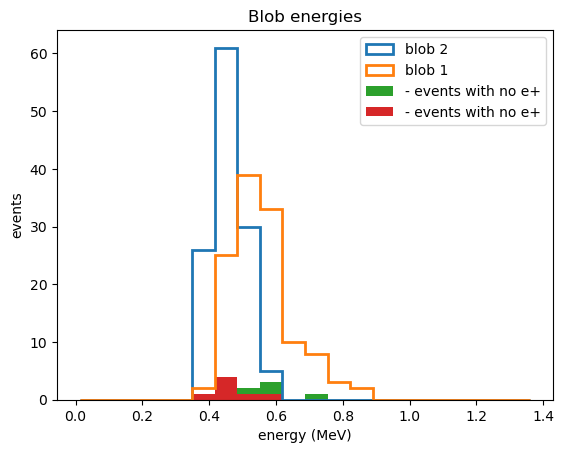

In [53]:
cut_list = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
fom = fom_calc(ecut_rel, cut_list, no_pos_data = ecut_no_positron_df, verbose = True)

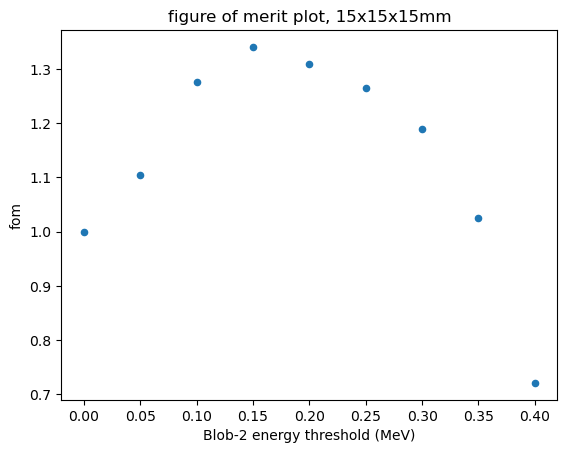

In [55]:
# plot fom
plt.scatter(cut_list, fom, s = 20)
plt.title("figure of merit plot, 15x15x15mm")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

fom_15x15x15 = fom

#### trying smaller range of E values

In [62]:
print(len(slimmed_E.index))
# so there are only this number of events!

NameError: name 'slimmed_E' is not defined

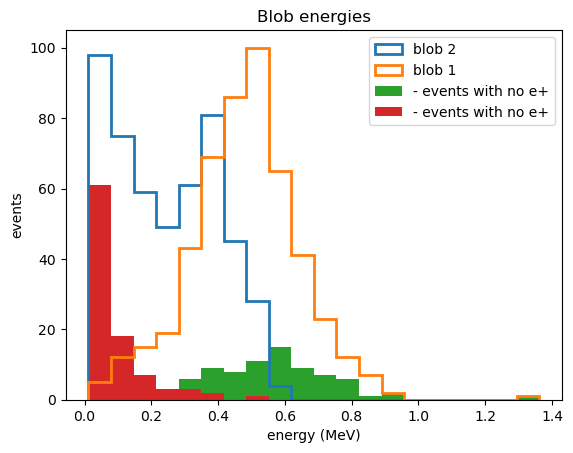

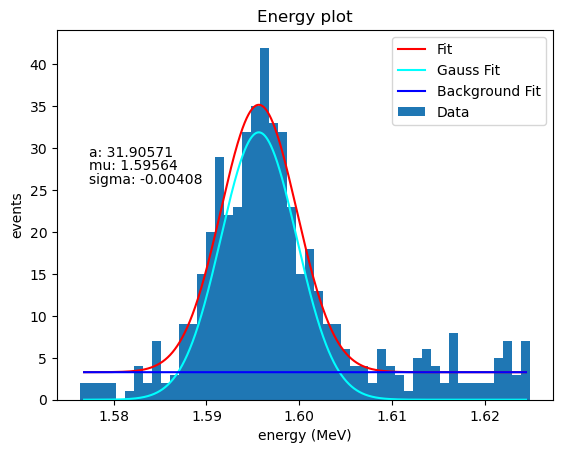

        Fitting output      
a: 31.9057 ± 1.3504
mu: 1.5956 ± 0.0002
sigma: -0.0041 ± 0.0002
C: 3.2852 ± 0.5477
ns0      = 335.74092483297693
nb0      = 675.7295358326277
total    = 1011
Event no = 500



        CUT 0 MeV       


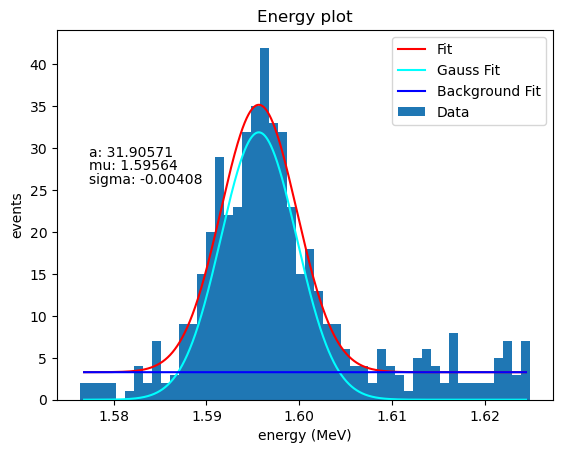

        Fitting output      
a: 31.9057 ± 1.3504
mu: 1.5956 ± 0.0002
sigma: -0.0041 ± 0.0002
C: 3.2852 ± 0.5477
ns - 335.74092483297693
nb - 675.7295358326277
total = 1011
Event no = 500

e_i: 1.0
b_i: 1.0
fom: 1.0


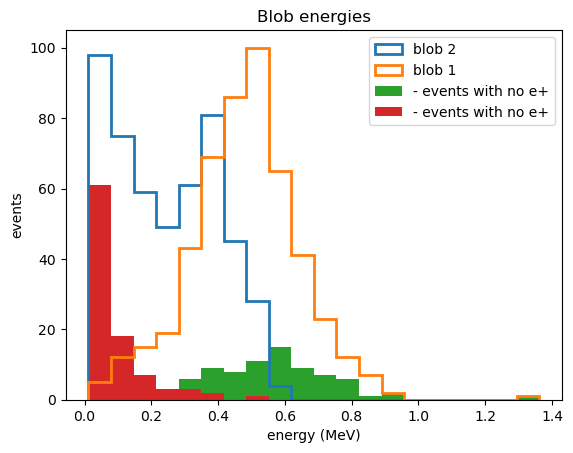




        CUT 0.05 MeV       


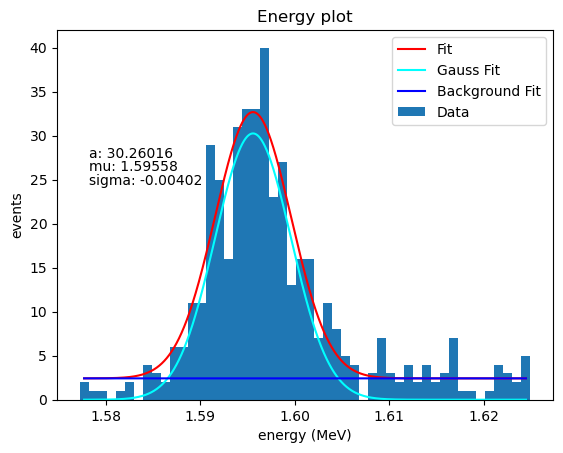

        Fitting output      
a: 30.2602 ± 1.6460
mu: 1.5956 ± 0.0002
sigma: -0.0040 ± 0.0003
C: 2.4270 ± 0.6697
ns - 319.653050160379
nb - 509.08379510851773
total = 829
Event no = 441

e_i: 0.9520824734708726
b_i: 0.7533839622404982
fom: 1.0968983546326005


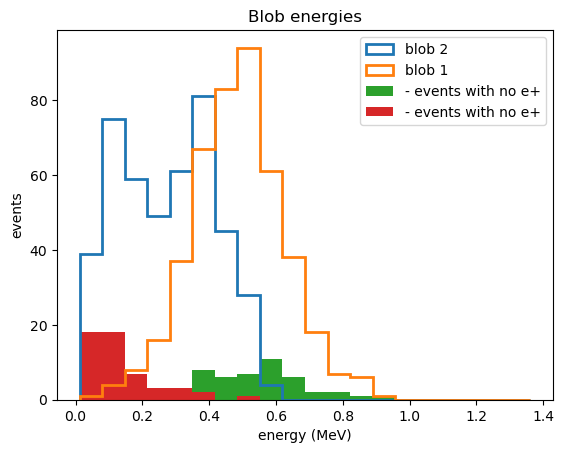




        CUT 0.1 MeV       


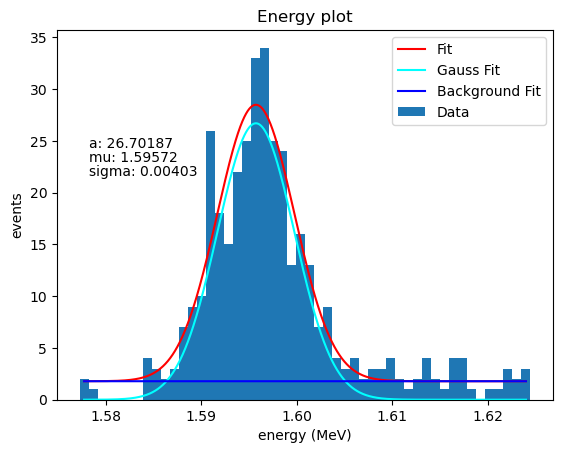

        Fitting output      
a: 26.7019 ± 1.3183
mu: 1.5957 ± 0.0002
sigma: 0.0040 ± 0.0002
C: 1.7871 ± 0.5420
ns - 285.6453296817659
nb - 378.22331163032123
total = 664
Event no = 375

e_i: 0.8507909180981365
b_i: 0.5597258837654299
fom: 1.1371955457480454


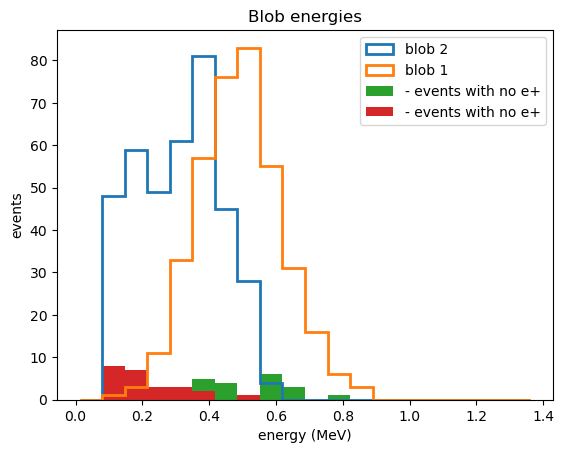




        CUT 0.15 MeV       


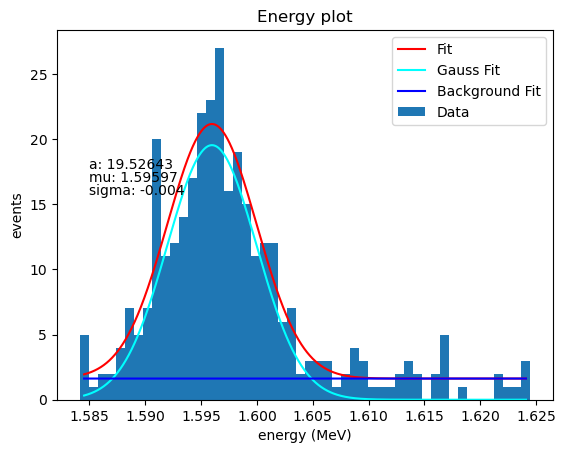

        Fitting output      
a: 19.5264 ± 1.0564
mu: 1.5960 ± 0.0002
sigma: -0.0040 ± 0.0003
C: 1.6240 ± 0.4886
ns - 242.1607176953013
nb - 402.2291162102824
total = 644
Event no = 323

e_i: 0.7212725640038385
b_i: 0.5952516426778052
fom: 0.9348654534694364


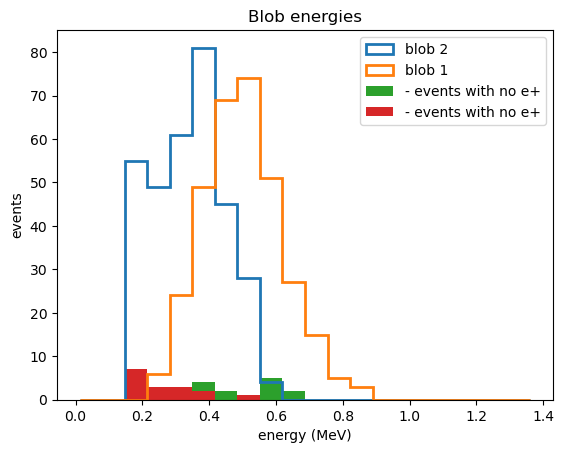




        CUT 0.2 MeV       


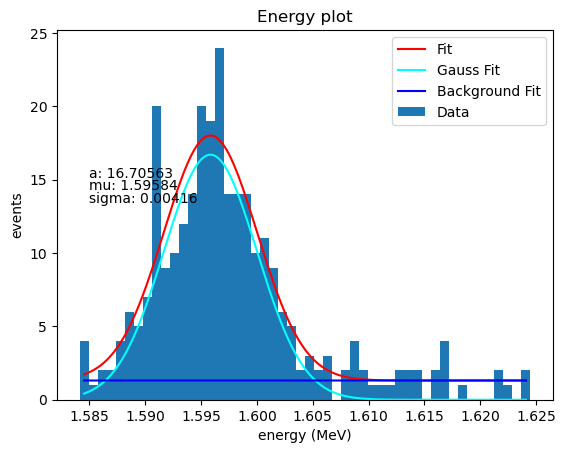

        Fitting output      
a: 16.7056 ± 1.0147
mu: 1.5958 ± 0.0003
sigma: 0.0042 ± 0.0003
C: 1.3109 ± 0.4847
ns - 215.9786061392189
nb - 324.68468119155375
total = 541
Event no = 281

e_i: 0.64328948354051
b_i: 0.4804950264479416
fom: 0.9280299735170265


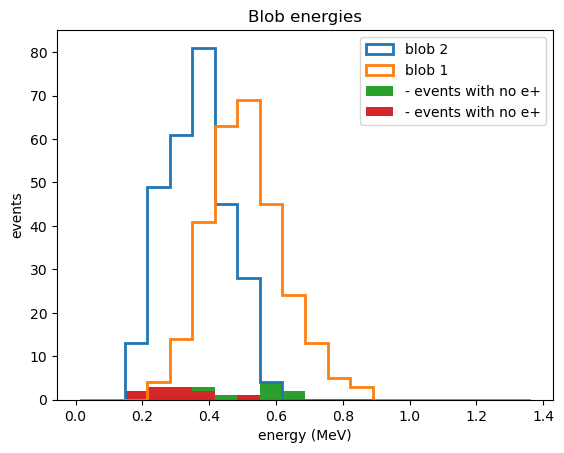

In [56]:
cut_list = [0, 0.05, 0.1, 0.15, 0.2]

# slim the data
slimmed_E = energy_cuts(ecut_rel, lower_e = 1.575, upper_e = 1.625, verbose = False)
slimmed_nopos = energy_cuts(ecut_no_positron_df, lower_e = 1.575, upper_e = 1.625, verbose = False)


fom_slimmed = fom_calc(slimmed_E, cut_list, no_pos_data = slimmed_nopos, verbose = True, binning = 50)

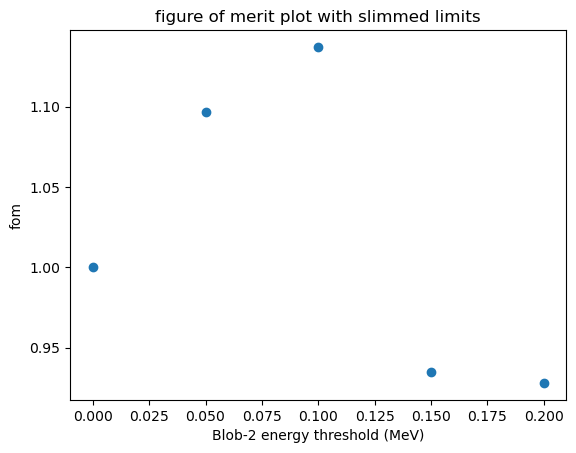

In [57]:
# plot fom
plt.scatter(cut_list, fom_slimmed)
plt.title("figure of merit plot with slimmed limits")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

#### trying normalised now

[150, 1.58, 0.006, 5]


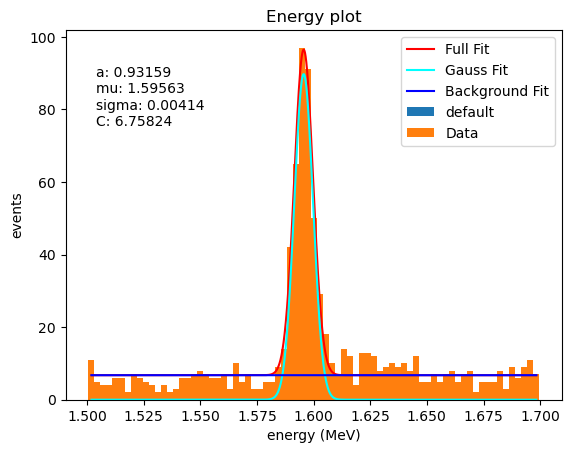

        Fitting output      
a: 0.9316 ± 0.0256
mu: 1.5956 ± 0.0001
sigma: 0.0041 ± 0.0001
C: 6.7582 ± 0.3865
ns = 0.9315868038289681
nb = 1.3516487690103973
True ns = 351.13171158603035
True nb = 509.46057176321466


In [58]:
# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 75, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)


# fitting
p0 = [150, 1.58, 0.006, 5]
gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

print(p0)
popt, pcov = curve_fit(gauss_bck_norm, centres, hist, p0, maxfev = 5000000)
plot_fit(gauss_bck_norm, centres, popt, gauss_bck_labels, lgnd='Full Fit', colour = 'red', popt_text = False)
plot_fit(gauss_norm, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = True)
plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_bck_labels)

bin_width = centres[1] - centres[0]

x_points = np.linspace(emin, emax, 100000)

ns0 = quad(gauss_norm, emin, emax, args = (popt[0], popt[1], popt[2]))
nb0 = quad(bck, emin, emax, args = popt[-1])
print('ns = {}'.format(ns0[0]))
print('nb = {}'.format(nb0[0]))

print('True ns = {}'.format(ns0[0]/bin_width))
print('True nb = {}'.format(nb0[0]/bin_width))

#### Lets actually do the FOM integral over the space defined in the RL paper
https://arxiv.org/pdf/2102.11931.pdf
3 sigma around the mean

In [56]:
def default_fit(data, bins = 75, verbose = False):
    '''
    Apply the expected fit to the data here,
    '''

    # find minima and maxima
    evalues = data['energy'].to_numpy()
    e_low = np.min(evalues) 
    e_high = np.max(evalues)

    # collect heights from histogram of energy
    hist, edges, patches = plot_hist(data, binning = bins, output = False, data = True)
    plt.clf()
    # convert edges to centres
    centres = shift_to_bin_centers(edges)


    # collect assumptions
    p1 = [1, 1.58, 0.006, 5]
    gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

    # fit function
    popt, pcov = curve_fit(gauss_bck, centres, hist, p1, maxfev = 5000000)

    if (verbose == True):
        plot_fit(gauss_bck, centres, popt, gauss_bck_labels)
        plot_fit(gauss, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = False)
        plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
        
        plot_hist(data, binning = bins, output = False, data = True, label='Data')
        plt.legend()
        plt.show()
        print_parameters(popt, pcov, gauss_bck_labels)

    # centres passed through to ensure we get the correct even numbers
    return (popt, pcov, gauss_bck_labels, centres)
        

def fom_calc(data, cut_list, no_pos_data = pd.DataFrame({'A' : []}), binning = 75, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    no_pos_data related to data with no positrons in it (background).
    Useful to visualise for 
    '''

    if ((verbose == True) and not (no_pos_data.empty)):
        blob_positron_plot(data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    output = default_fit(data, bins = binning, verbose = True)

    popt = output[0]
    print(popt)
    pcov = output[1]
    gauss_bck_labels = output[2]
    centres = output[3]

    # take bin widths to calculate number of events
    bin_width = centres[1] - centres[0]

    # signal is integration of function over the space
    ns0 = quad(gauss, emin, emax, args = tuple(popt[:-1]))/bin_width
    nb0 = quad(bck, emin, emax, args = popt[-1])/bin_width

    if (verbose == True):
        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(data.index)))


    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        print("")
        print("")
        print("")
        
        print("==========================")
        print("        CUT {} MeV       ".format(cut_list[i]))
        print("==========================")
        # remove blob 2 values below value on cut_list
        data = data[(data['eblob2'] > cut_list[i])]
        if not (no_pos_data.empty):
            no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]
        # apply fit to the new data 
        if (verbose == True):
            output = default_fit(data, bins = binning, verbose = True)
        else:
            output = default_fit(data, bins = binning, verbose = False)
        
        # collect values
        popt = output[0]
        pcov = output[1]
        gauss_bck_labels = output[2]
        centres = output[3]

        # take bin widths to calculate number of events
        bin_width = centres[1] - centres[0]

        # collect ns and nb
        ns = quad(gauss, emin, emax, args = tuple(popt[:-1]))/bin_width
        nb = quad(bck, emin, emax, args = popt[-1])/bin_width

        if (verbose == True):
            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb[0]))
            print("total = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(data.index)))
        # produce fom value (DISCREETLY NOW AS IT ISNT WORKING)
        e_check     = ns[0]/ns0[0]
        b_check     = nb[0]/nb0[0]
        fom_check   = e_check/np.sqrt(b_check)
        

        print('\ne_i: {}\nb_i: {}\nfom: {}'.format(e_check, b_check, fom_check))

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        if ((verbose == True) and not (no_pos_data.empty)):
            blob_positron_plot(data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom






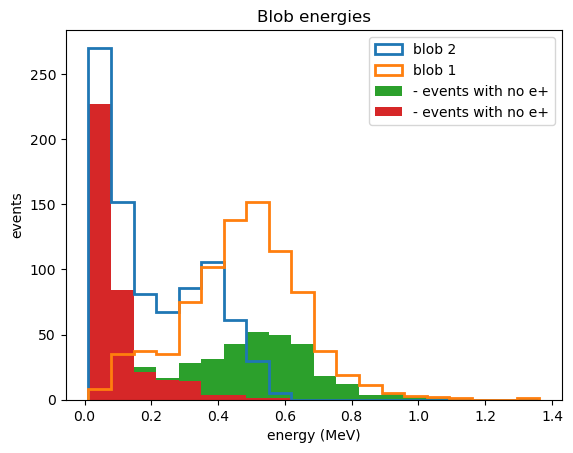

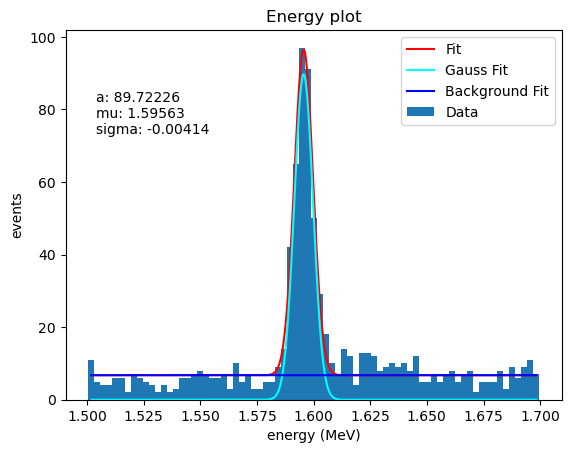

        Fitting output      
a: 89.7223 ± 2.3400
mu: 1.5956 ± 0.0001
sigma: -0.0041 ± 0.0001
C: 6.7582 ± 0.3865
[ 8.97222609e+01  1.59563378e+00 -4.14222438e-03  6.75823914e+00]
ns0      = 351.132063897691
nb0      = 509.46021735179534
total    = 861
Event no = 858



        CUT 0 MeV       


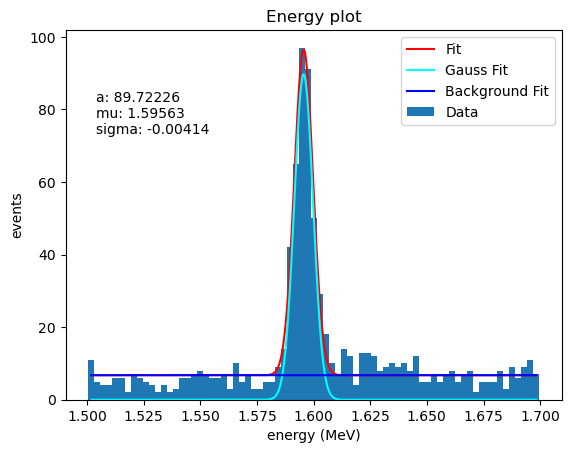

        Fitting output      
a: 89.7223 ± 2.3400
mu: 1.5956 ± 0.0001
sigma: -0.0041 ± 0.0001
C: 6.7582 ± 0.3865
ns - 351.132063897691
nb - 509.46021735179534
total = 861
Event no = 858

e_i: 1.0
b_i: 1.0
fom: 1.0


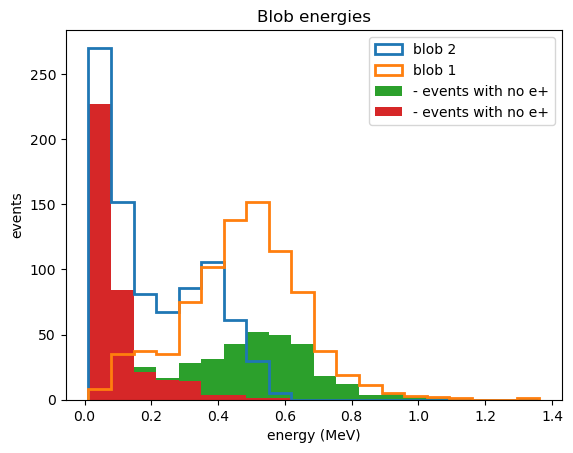




        CUT 0.05 MeV       


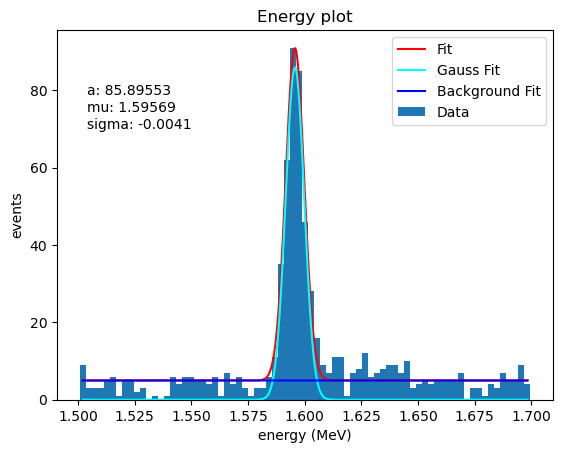

        Fitting output      
a: 85.8955 ± 2.2379
mu: 1.5957 ± 0.0001
sigma: -0.0041 ± 0.0001
C: 4.9758 ± 0.3676
ns - 332.8159675192166
nb - 375.09261297246024
total = 708
Event no = 706

e_i: 0.9478370155799524
b_i: 0.7362549620109968
fom: 1.104636902812951


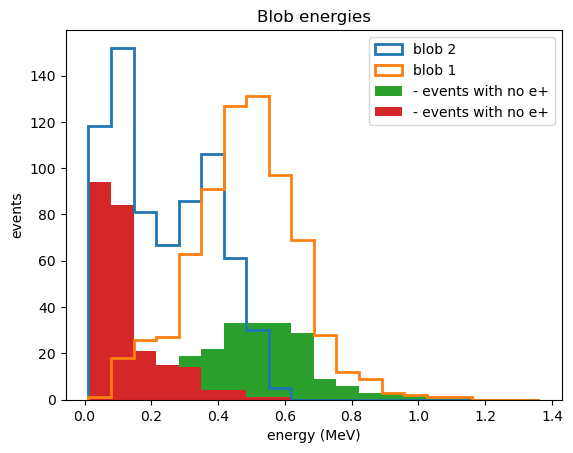




        CUT 0.1 MeV       


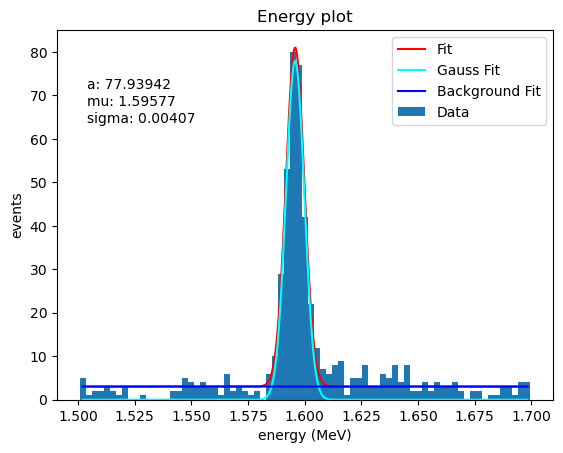

        Fitting output      
a: 77.9394 ± 1.7742
mu: 1.5958 ± 0.0001
sigma: 0.0041 ± 0.0001
C: 3.0293 ± 0.2903
ns - 299.8013544975989
nb - 228.36061022486854
total = 528
Event no = 527

e_i: 0.8538136653477243
b_i: 0.44824031876698955
fom: 1.2752861474807295


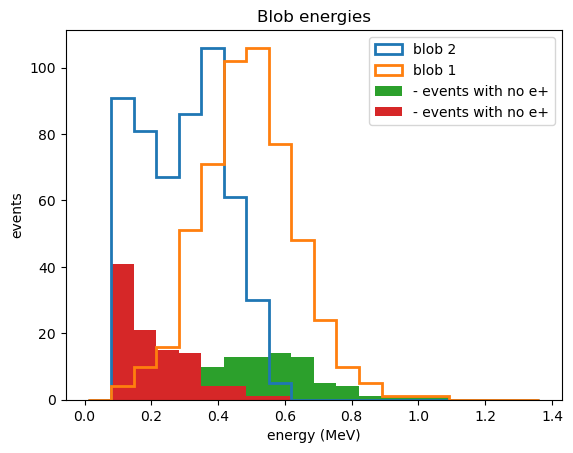




        CUT 0.15 MeV       


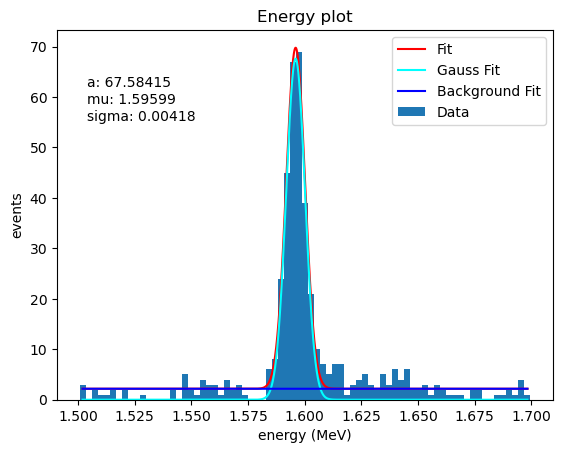

        Fitting output      
a: 67.5842 ± 1.4865
mu: 1.5960 ± 0.0001
sigma: 0.0042 ± 0.0001
C: 2.1742 ± 0.2468
ns - 266.93578470303856
nb - 163.8981749353111
total = 431
Event no = 430

e_i: 0.76021477998892
b_i: 0.3217094669084538
fom: 1.3403073164861299


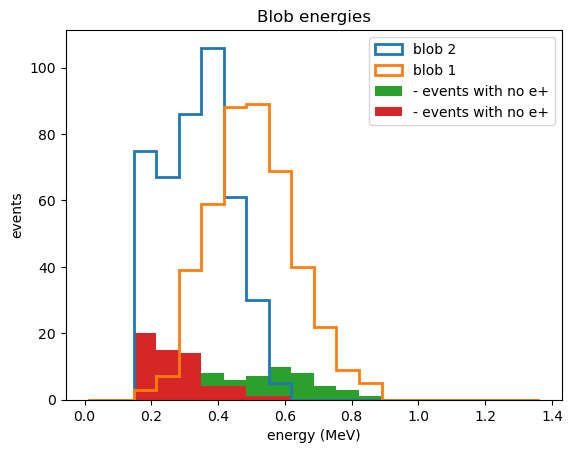




        CUT 0.2 MeV       


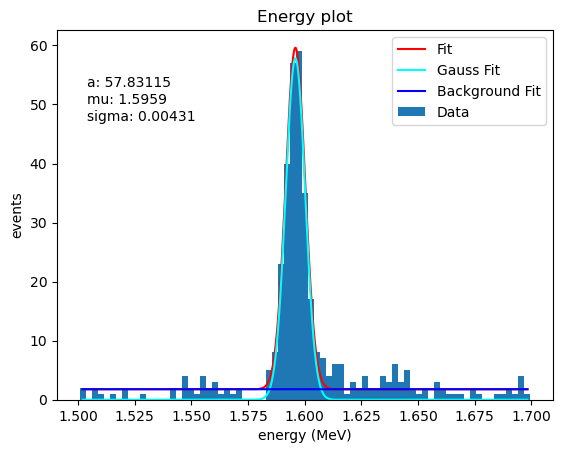

        Fitting output      
a: 57.8311 ± 1.2616
mu: 1.5959 ± 0.0001
sigma: 0.0043 ± 0.0001
C: 1.7767 ± 0.2132
ns - 235.75017595487324
nb - 133.9313055148948
total = 370
Event no = 369

e_i: 0.6714003082998524
b_i: 0.26288864361397585
fom: 1.309470212064622


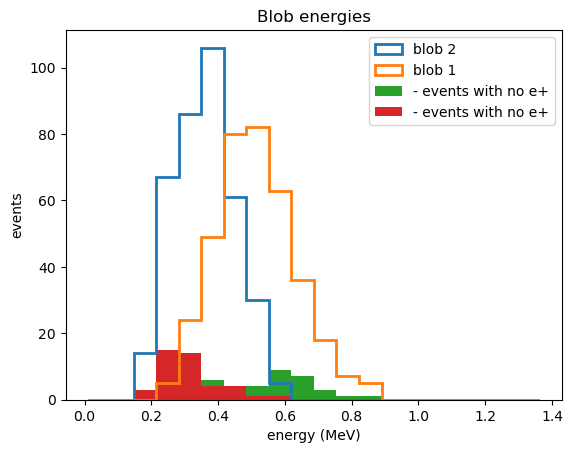




        CUT 0.25 MeV       


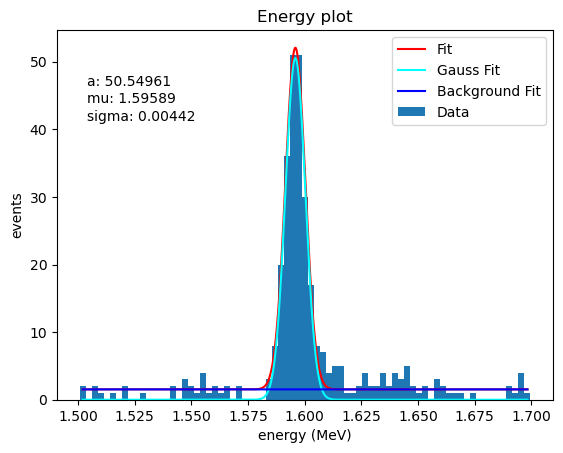

        Fitting output      
a: 50.5496 ± 1.1353
mu: 1.5959 ± 0.0001
sigma: 0.0044 ± 0.0001
C: 1.5302 ± 0.1945
ns - 211.23221392274414
nb - 115.35474459443675
total = 327
Event no = 326

e_i: 0.6015748364817252
b_i: 0.22642542178083622
fom: 1.2642328443874284


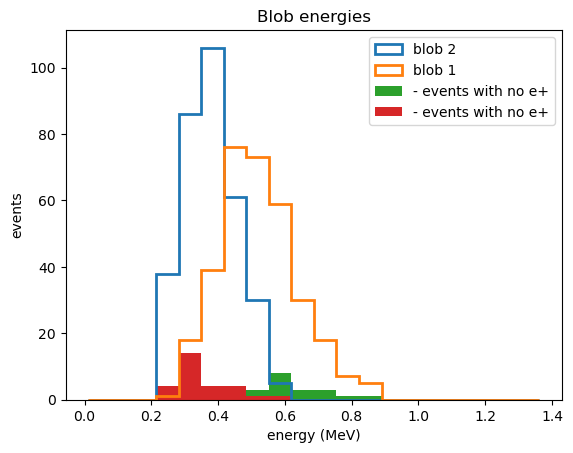




        CUT 0.3 MeV       


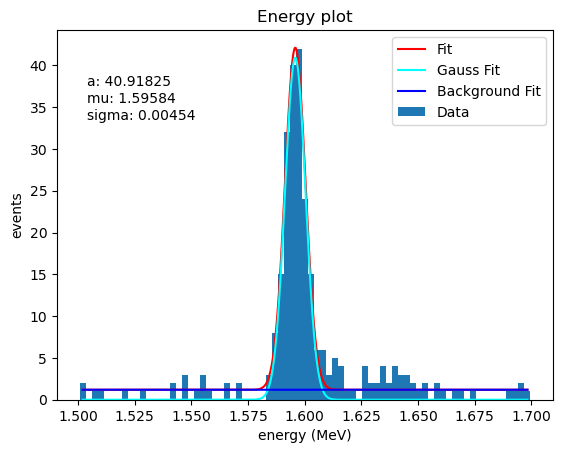

        Fitting output      
a: 40.9183 ± 1.0289
mu: 1.5958 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 1.1934 ± 0.1788
ns - 175.49324975109528
nb - 89.9645155492186
total = 265
Event no = 265

e_i: 0.499792721299951
b_i: 0.17658791105782418
fom: 1.1893493579458427


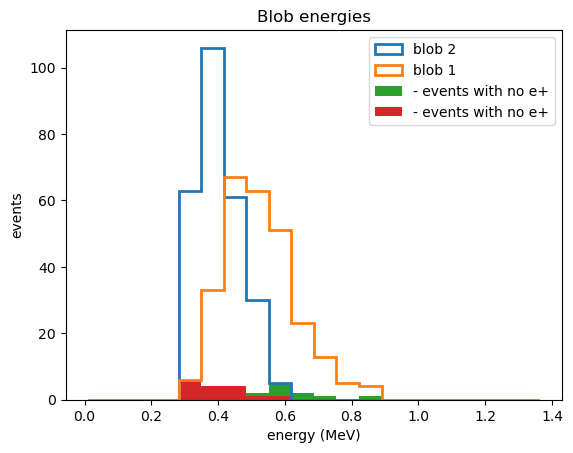




        CUT 0.35 MeV       


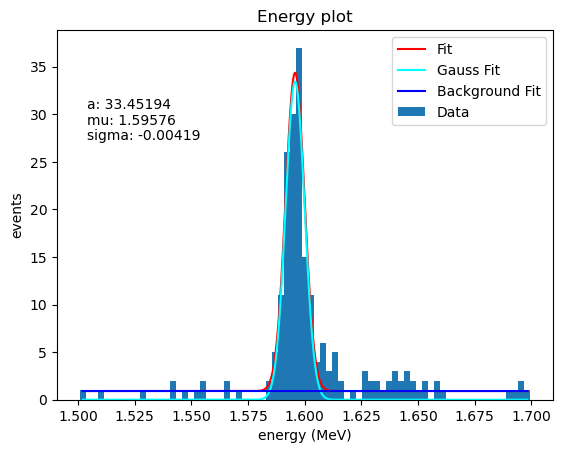

        Fitting output      
a: 33.4519 ± 1.1656
mu: 1.5958 ± 0.0002
sigma: -0.0042 ± 0.0002
C: 0.9142 ± 0.1938
ns - 132.43562019006717
nb - 68.91503813721067
total = 201
Event no = 201

e_i: 0.3771675497816537
b_i: 0.13527069590523705
fom: 1.0254924287616036


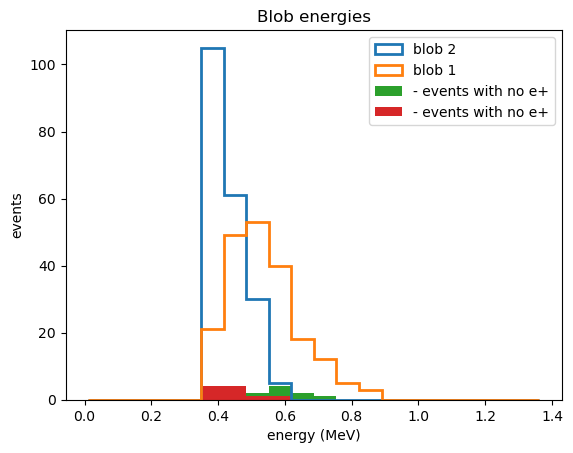




        CUT 0.4 MeV       


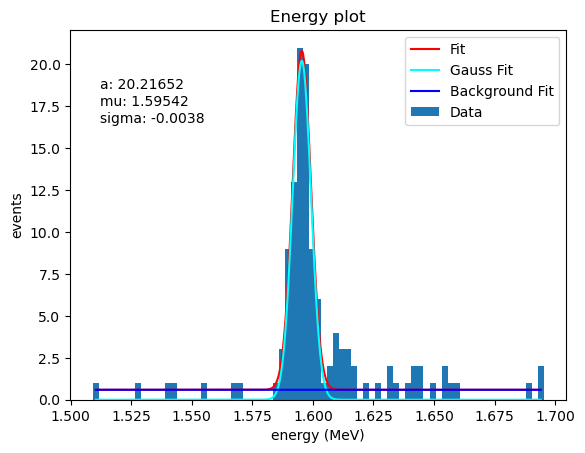

        Fitting output      
a: 20.2165 ± 0.7399
mu: 1.5954 ± 0.0002
sigma: -0.0038 ± 0.0002
C: 0.5929 ± 0.1209
ns - 77.53334466872397
nb - 47.76744015588029
total = 125
Event no = 122

e_i: 0.22080964013390353
b_i: 0.09376088363519
fom: 0.7211194078992933


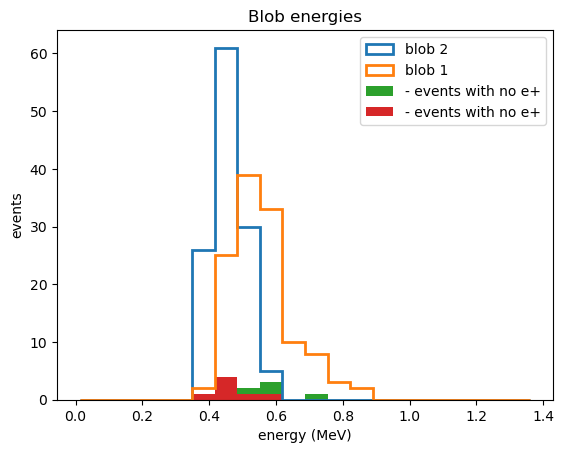

In [57]:
cut_list = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
fom_3sig = fom_calc(ecut_rel, cut_list, no_pos_data = ecut_no_positron_df, verbose = True)

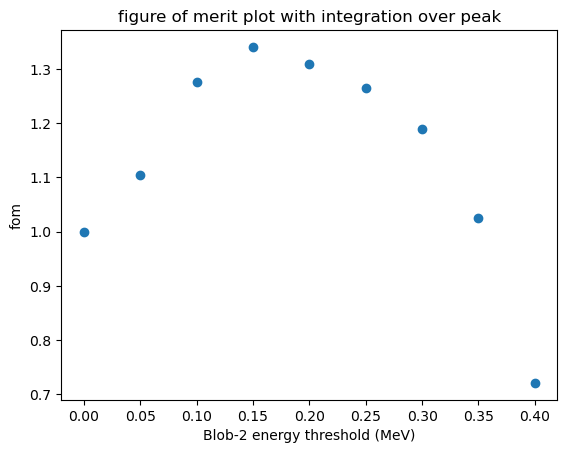

[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
[1.0, 1.104636902812951, 1.2752861474807295, 1.3403073164861299, 1.309470212064622, 1.2642328443874284, 1.1893493579458427, 1.0254924287616036, 0.7211194078992933]


In [58]:
# plot fom
plt.scatter(cut_list, fom_3sig)
plt.title("figure of merit plot with integration over peak")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()
print(cut_list)
print(fom_3sig)

In [ ]:
# GRAVEYARD
break;


In [ ]:

def fom_calc_3sig(data, cut_list, no_pos_data = pd.DataFrame({'A' : []}), binning = 75, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    no_pos_data related to data with no positrons in it (background).
    Useful to visualise for 
    '''

    if ((verbose == True) and not (no_pos_data.empty)):
        blob_positron_plot(data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    output = default_fit(data, bins = binning, verbose = True)

    popt = output[0]
    pcov = output[1]
    gauss_bck_labels = output[2]
    centres = output[3]

    # take bin widths to calculate number of events
    bin_width = centres[1] - centres[0]

    # collect min and maximum around the peak (3 sigma around mean)
    sig_min = popt[1] + 3*abs(popt[2])
    sig_max = popt[1] - 3*abs(popt[2])


    # signal is integration of function over the space
    ns0 = quad(gauss, sig_min, sig_max, args = tuple(popt[:-1]))/bin_width
    nb0 = quad(bck, sig_min, sig_max, args = popt[-1])/bin_width

    if (verbose == True):
        print("Integrating around {} and {}".format(sig_min, sig_max))
        print("")
        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(energy_cuts(data, lower_e = sig_min, upper_e = sig_max).index)))


    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        print("")
        print("")
        print("")
        
        print("==========================")
        print("        CUT {} MeV       ".format(cut_list[i]))
        print("==========================")
        # remove blob 2 values below value on cut_list
        data = data[(data['eblob2'] > cut_list[i])]
        if not (no_pos_data.empty):
            no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]
        # apply fit to the new data 
        if (verbose == True):
            output = default_fit(data, bins = binning, verbose = True)
        else:
            output = default_fit(data, bins = binning, verbose = False)
        
        # collect values
        popt = output[0]
        pcov = output[1]
        gauss_bck_labels = output[2]
        centres = output[3]

        # take bin widths to calculate number of events
        bin_width = centres[1] - centres[0]

        # collect min and maximum around the peak (3 sigma around mean)
        sig_min = popt[1] + 3*abs(popt[2])
        sig_max = popt[1] - 3*abs(popt[2])


        # signal is integration of function over the space
        ns = quad(gauss, sig_min, sig_max, args = tuple(popt[:-1]))/bin_width
        nb = quad(bck, sig_min, sig_max, args = popt[-1])/bin_width

        if (verbose == True):
            print("Integrating around {} and {}".format(sig_min, sig_max))
            print("")
            print('ns0      = {}'.format(ns[0]))
            print('nb0      = {}'.format(nb[0]))
            print("total    = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(energy_cuts(data, lower_e = sig_min, upper_e = sig_max).index)))
        # produce fom value (DISCREETLY NOW AS IT ISNT WORKING)
        e_check     = ns[0]/ns0[0]
        b_check     = nb[0]/nb0[0]
        fom_check   = e_check/np.sqrt(b_check)
        

        print('\ne_i: {}\nb_i: {}\nfom: {}'.format(e_check, b_check, fom_check))

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        if ((verbose == True) and not (no_pos_data.empty)):
            blob_positron_plot(data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom




